In [1]:
# import MODULES
import numpy as np
import matplotlib.pyplot as plt
import xarray as xray
from glob import glob
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
import cartopy.crs as ccrs
from matplotlib.cm import get_cmap
from datetime import datetime
from netCDF4 import Dataset,MFDataset
#from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim, ALL_TIMES, geo_bounds
import cmaps
import matplotlib.patches as mpatches
#import scipy.stats as st
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import matplotlib.ticker as mticker
#import wrf
import sys
#wrf.omp_enabled()
import pandas as pd
import matplotlib
#import seaborn as sns
#sns.set_style('whitegrid')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


import warnings
from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore")

In [2]:
def spatial_plot(ax,lat,lon,dat,cart,ran,cmpi,title):
    
    resol_N = [[75,90],[23,30],['1971-1-1','2010-12-31'],'N_box']
    resol_S = [[73,81],[14,22],['1971-1-1','2010-12-31'],'S_box']
    plotpath = '/home/kaushik/Desktop/plots_spatial/'
    
    # Mollweide
    dmin=ran[0]
    dmax = ran[-1]
    #    dmin=-1*np.max([np.abs(np.percentile(dat,1)),np.percentile(dat,99)])
    #    dmax=np.max([np.abs(np.percentile(dat,1)),np.percentile(dat,99)])
    print([dmin,dmax])
    pmesh = ax.pcolormesh(lon,lat,dat,vmin=dmin,vmax=dmax,transform=ccrs.PlateCarree(),cmap=cmpi)
    #pmesh = ax.contourf(lon,lat,dat,np.linspace(dmin,dmax,18),transform=ccrs.PlateCarree(),cmap=cmpi,extend = 'both')
    #pmesh = ax.pcolormesh(lon,lat,dat,transform=ccrs.PlateCarree(),cmap=cmpi)
    ax.coastlines(resolution='10m')
    #ax.add_patch(mpatches.Rectangle(xy=[resol_N[0][0], resol_N[1][0]], width=resol_N[0][1]-resol_N[0][0], height=resol_N[1][1]-resol_N[1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
    #ax.add_patch(mpatches.Rectangle(xy=[resol_S[0][0], resol_S[1][0]], width=resol_S[0][1]-resol_S[0][0], height=resol_S[1][1]-resol_S[1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
    fname = '/mnt/nas/DATA/kaushik/scripts/Python/India_shapefiles/India.shp'
    shape_feature = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor='none',edgecolor='black')
    ax.add_feature(shape_feature)
    plt.title(title)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='black', alpha=0.3, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    #gl.xlines = False
    gl.xlocator = mticker.FixedLocator([45,60,75,90,105,120])
    gl.ylocator = mticker.FixedLocator([-25,-10, 5, 20, 35,50])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    #plt.savefig(plotpath+title+'_JA_diff.png',bbox_inches='tight',dpi=300)
    #plt.clf()
    #plt.close('all')
    return ax,pmesh,gl

In [3]:
import geopandas as gpd
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='lat', longitude='lon',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xray.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    """ Create a new coord for the xr_da indicating whether or not it
         is inside the shapefile

        Creates a new coord - "coord_name" which will have integer values
         used to subset xr_da for plotting / analysis/

        Usage:
        -----
        precip_da = add_shape_coord_from_data_array(precip_da, "awash.shp", "awash")
        awash_da = precip_da.where(precip_da.awash==0, other=np.nan)
    """
    # 1. read in shapefile
    shp_gpd = gpd.read_file(shp_path)

    # 2. create a list of tuples (shapely.geometry, id)
    #    this allows for many different polygons within a .shp file (e.g. States of US)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]

    # 3. create a new coord in the xr_da which will be set to the id in `shapes`
    xr_da[coord_name] = rasterize(shapes, xr_da.coords,
                               longitude='lon', latitude='lat')

    return xr_da


def reg_sel():
    # Region Def.
    resol = {}
    resol['R1'] = [[72.5,81],[33,38]]
    #resol['R2'] = [[75,81,81,88,88,75],[33,33,28,28,24,24]]
    resol['R2'] = [[75,88],[24,33]]
    resol['R3'] = [[88,98],[22,30]]
    resol['R4'] = [[68,75],[22,30]]
    resol['R5'] = [[75,88],[17,24]]
    resol['R6'] = [[72,81],[8,17]]
    resol['ind'] = [[65,95],[5,39]]

    resol['IGP'] = [[75,83],[23,28]]#,['1971-1-1','2010-12-31'],'N_box']
    resol['EI'] = [[85,90],[20,25]]
    resol['S'] = [[73,81],[14,22]]
    resol['D'] = [[67+2,73+2],[23-2,30-2]]
    return resol



In [4]:
import scipy.stats as st
import pandas as pd
from collections import OrderedDict


def calc_PCC(WRF, OBS):
    return np.round(st.pearsonr(WRF,OBS)[0],2)
def calc_RMSE(WRF, OBS):
    return np.round(np.sqrt(((WRF - OBS)**2).mean()).data,2)
def calc_NMSE(WRF, OBS):
    return np.round((((WRF - OBS)**2).mean()/(WRF.mean() * OBS.mean())).data *100,1)
def calc_NMB(WRF, OBS):
    return np.round(((WRF - OBS).sum()/OBS.sum()).data*100,2)
def func_tp(tperiod):
    tslice = {}
    tslice['seas_std'] = ['MAM','DJF','JJA','SON']
    tslice['seas'] = ['JJAS','ON']
    tslice['Annual'] = ['Annual']
    tslice['months'] = list(np.linspace(1,12,12))
    for j in tslice.items():
        if tperiod in j[1]:
            tslice = j[0]
    return tslice                

def regionX(dset,reg):
    resol = reg_sel()
    data = dset.sel(lat=slice(resol[reg][1][0], resol[reg][1][1]),lon=slice(resol[reg][0][0], resol[reg][0][1]))
    return data
def timeX(dset,tperiod):
    ts = func_tp(tperiod)
    if ts == 'seas_std':
        data = dset.sel(time = dset['time.season'] == tperiod)
    elif ts == 'Annual':
        data = dset.sel(time = dset['time.year'] == 2015)
    elif ts == 'months':
        data = dset.sel(time = dset['time.month'] == tperiod)
    elif (ts == 'seas') & (tperiod == 'JJAS'):
        data = dset.sel(time = (dset['time.month']>=6) & (dset['time.month']<=9))
    elif (ts == 'seas') & (tperiod == 'ON'):
        data = dset.sel(time = (dset['time.month']>=10) & (dset['time.month']<=11))
    else:
        print('invalid time period')
    return data
def indshp(dset):
    add_shape_coord_from_data_array(dset, '/mnt/nas/DATA/kaushik/scripts/Python/India_shapefiles/India.shp', 'ind')
    data = dset.where(dset.ind==0)
    return data
def tsX(dset,region='R1',tperiod='MAM'):
    data = timeX(indshp(regionX(dset,region)),tperiod)
    data = data.mean(['lat','lon']).resample(time='1D').mean()
    return data

def calc_stats(model_dset,obs_dset,region='R3',tperiod='MAM',obs_name='MODIS',scale=1):
    STATS = {}
    WRF = (tsX(model_dset,region,tperiod)*scale).compute()
    OBS = tsX(obs_dset,region,tperiod).compute()
    
    #STATS['PCC'] = calc_PCC(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['NMB'] = calc_NMB(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['RMSE'] = calc_RMSE(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['NMSE'] = calc_NMSE(WRF[np.isfinite(OBS)],OBS[np.isfinite(OBS)])
    STATS['O'] = np.round(OBS[np.isfinite(OBS)].mean().data,3)
    STATS['M'] = np.round(WRF[np.isfinite(OBS)].mean().data,3)
    return STATS

In [5]:
ranspec= {} 
ranspec['pr']=[0,40]
ranspec['rsds'] = [0,400]
ranspec['zmla'] = [200,1200]

def ext_CBMZ(vname):
    REL_PATH = '/mnt/nas/DATA/Common/CBMZ_IISER/'
    FNAME = vname+'_daily_2015.nc'
    return xray.open_dataset(REL_PATH+FNAME)[vname]

def ext_WRF(vname,dmap):
    dset_WRF = []
    for fl in dmap:
        REL_PATH = '/mnt/nas/DATA/kaushik/proc/'+fl+'/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/*/r1i1p1f1/'+'1hr'+'/'+vname+'/gn/'
        #REL_PATH = '/mnt/stime/scratch/PartclAeroResLab/kaushik.reddy.m/proc/'+fl+'/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/*/r1i1p1f1/'+'1hr'+'/'+vname+'/gn/'
        flist = sorted(glob(REL_PATH+'*BASELINE*2015*'))
        print(flist,len(flist))
        dset_base = xray.concat([xray.open_dataset(f,chunks={'time':2})[vname] for f in flist],'time')
        dset_WRF.append(dset_base)

    dset_WRF = xray.concat(dset_WRF,pd.Index(dmap,name='exp'))
    return dset_WRF
def ext_OBS():
    dset_OBS = {}

    IMD_path = '/mnt/nas/DATA/Common/Observations/IMD/'
    IMD_fname = 'precip2015.nc'
    dset_OBS['IMD'] = xray.open_dataset(IMD_path+IMD_fname)['rf'].sel(lat=slice(0,40),lon=slice(65,98))

    CERES_path = '/mnt/nas/DATA/Common/Observations/CERES/'
    CERES_fname = 'CERES_EBAF-Surface_Edition4.0_200003-201803.nc'
    dset = xray.open_dataset(CERES_path+CERES_fname)['sfc_sw_down_clr_mon']
    dset_OBS['CERES-SWDNC'] = dset
    
    CERES_fname = 'CERES_EBAF-TOA_Edition4.0_200003-201810.nc'
    dset_TOA = xray.open_dataset(CERES_path+CERES_fname)
    dset_OBS['CERES-OLR'] = dset_TOA['toa_lw_all_mon']
    dset_OBS['CERES-SWUP'] = dset_TOA['toa_sw_all_mon']
    
    ERA_path = '/mnt/nas/DATA/Common/Observations/ERA-interim/'
    ERA_fname = 'forecast.nc'
    ERA_dset = xray.open_dataset(ERA_path+ERA_fname)['blh']
    ERA_dset = ERA_dset.reindex(latitude=ERA_dset.latitude[::-1])
    dset_OBS['PBLH'] = ERA_dset.rename({'longitude': 'lon','latitude': 'lat'}).sel(time = ERA_dset['time.year']==2015)
    
    CRU_path = '/mnt/nas/DATA/Common/Observations/2mT/'
    CRU_fname = 'cru_ts4.03.2011.2018.tmp.dat.nc'
    CRU_dset = xray.open_dataset(CRU_path+CRU_fname)['tmp']
    dset_OBS['CRU-T'] = CRU_dset+273
    
    
    return dset_OBS



In [6]:

def validation(stdvname,tperiod,dset_OBS,dset_WRF,ravg,rdiff):
    with ProgressBar():
        OBS_mean = regionX(timeX(dset_OBS,tperiod),'ind').mean('time').compute()
        WRF_mean = regionX(timeX(dset_WRF,tperiod),'ind').mean('time').compute()
        
    cart = ccrs.PlateCarree()
    resol = reg_sel()

    ran = ravg
    cmpi = plt.cm.jet
    fig = plt.figure(figsize= (15,15))
    
    j=0
    tperiod = str(tperiod) 
    title= stdvname+' | '+str(OBS_mean.name)+' | '+tperiod
    ax = fig.add_axes([0.1+j*0.5,0.1,0.5,0.5],projection=cart)
    ax,pmesh,gl = spatial_plot(ax,OBS_mean.lat,OBS_mean.lon,OBS_mean,cart,ran,cmpi,title)
    
    gl.ylabels_left = True

    ###################
    # Draw Patches
    ###################
    for reg in ['R1','R2','R3','R4','R5','R6']:
        if reg=='R2':
            ax.add_patch(mpatches.Polygon(xy=np.array([[75,75,80,80,88,88],[24,33,33,28,28,24]]).T,facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
            pos = np.array(resol[reg]).mean(axis=1)
            ax.text(pos[0],pos[1], reg, style ='italic', fontsize = 15, color ="black",transform=ccrs.PlateCarree())
        else:
            pos = np.array(resol[reg]).mean(axis=1)
            ax.add_patch(mpatches.Rectangle(xy=[resol[reg][0][0], resol[reg][1][0]], width=resol[reg][0][1]-resol[reg][0][0], height=resol[reg][1][1]-resol[reg][1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
            ax.text(pos[0]-1.5,pos[1]-1, reg, style ='italic', fontsize = 15, color ="black",transform=ccrs.PlateCarree())

    i=1
    #for i in range(WRF_mean.shape[0]):
    
    title = stdvname+' | '+str(WRF_mean[0].exp.values)+' | '+tperiod
    ax = fig.add_axes([0.1+(i)*0.5,0.1,0.5,0.5],projection=cart)
    ax,pmesh,gl = spatial_plot(ax,WRF_mean.lat,WRF_mean.lon,WRF_mean.isel(exp=0),cart,ran,cmpi,title)

    gl.ylabels_left = False
    gl.xlabels_bottom = True

    cax = fig.add_axes([0.1+(i+1)*0.5,0.1,0.02,0.5])
    cbar =  plt.colorbar(pmesh,extend='max', cax=cax)
    cbar.ax.tick_params(labelsize=30)

    import cmaps
    cmpi = cmaps.ViBlGrWhYeOrRe
    
    WRF_interp = WRF_mean.sel(lat=OBS_mean.lat,lon=OBS_mean.lon,method='nearest')
    
    ran = rdiff
    #for i in range(WRF_mean.shape[0]):
    title= stdvname+' | '+str(WRF_mean[0].exp.values)+' - MODIS | '+tperiod
    ax = fig.add_axes([0.2+(i+1)*0.5,0.1,0.5,0.5],projection=cart)
    ax,pmesh,gl = spatial_plot(ax,OBS_mean.lat,OBS_mean.lon,WRF_interp.isel(exp=0) - OBS_mean.data,cart,ran,cmpi,title)

    gl.ylabels_left = False
    gl.xlabels_bottom = True
    
    cax = fig.add_axes([0.2+(i+2)*0.5,0.1,0.02,0.5])
    cbar =  plt.colorbar(pmesh,extend='both', cax=cax)
    cbar.ax.tick_params(labelsize=30)

    #plt.savefig('AOD_spatial_diff_'+str(tperiod)+'.png',bbox_inches='tight',dpi=100)
    #plt.clf()
    #plt.close('all')

In [40]:
def save_stats(dset_WRF,dset_OBS,tperiod):
    for exp in range(dset_WRF.shape[0]):
        with pd.ExcelWriter(dset_OBS.name+'_'+dmap[exp]+'.xlsx') as writer:
            for reg in ['R1','R2','R3','R4','R5','R6','ind']:
                sts = {}
                for mon in tperiod:
                    x = calc_stats(dset_WRF.isel(exp=exp),dset_OBS.sel(time = dset_OBS['time.year']==2015),region=reg,tperiod=mon,obs_name=dset_OBS.name,scale=scale)
                    sts[mon] = x
                sts = pd.DataFrame(sts).T
                sts.to_excel(writer,sheet_name=reg)

                
                
                
def panel_difference(dset_WRF,dset_OBS, rmean, rdiff, tp=['DJF','MAM']):
    from dask.diagnostics import ProgressBar
    import dask
    for tperiod in tp:
        print(tperiod)
        OBS_mean = regionX(timeX(dset_OBS,tperiod),'ind').mean('time').compute()
        WRF_mean = regionX(timeX(dset_WRF,tperiod),'ind').mean('time').compute()
        cart = ccrs.PlateCarree()
        resol = reg_sel()
        ran = rmean#[0,0.3]
        cmpi = plt.cm.jet
        fig = plt.figure(figsize= (15,15))
        #'''
        j=0
        tperiod = str(tperiod) 
        title= dset_OBS.name+' | '+tperiod
        ax = fig.add_axes([0.1+j*0.5,0.1,0.5,0.5],projection=cart)
        ax,pmesh,gl = spatial_plot(ax,OBS_mean.lat,OBS_mean.lon,OBS_mean,cart,ran,cmpi,title)
        gl.ylabels_left = True
        ###################
        # Draw Patches
        ###################
        for reg in ['R1','R2','R3','R4','R5','R6']:
            if reg=='R2':
                ax.add_patch(mpatches.Polygon(xy=np.array([[75,75,80,80,88,88],[24,33,33,28,28,24]]).T,facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
                pos = np.array(resol[reg]).mean(axis=1)
                ax.text(pos[0],pos[1], reg, style ='italic', fontsize = 15, color ="black",transform=ccrs.PlateCarree())
            else:
                pos = np.array(resol[reg]).mean(axis=1)
                ax.add_patch(mpatches.Rectangle(xy=[resol[reg][0][0], resol[reg][1][0]], width=resol[reg][0][1]-resol[reg][0][0], height=resol[reg][1][1]-resol[reg][1][0],facecolor='none',edgecolor='black',transform=ccrs.PlateCarree()))
                ax.text(pos[0]-1.5,pos[1]-1, reg, style ='italic', fontsize = 15, color ="black",transform=ccrs.PlateCarree())
        for i in range(WRF_mean.shape[0]):
            title = str(WRF_mean[i].name)+' | '+str(WRF_mean[i].exp.values)+' | '+tperiod
            ax = fig.add_axes([0.1+(i+1)*0.5,0.1,0.5,0.5],projection=cart)
            ax,pmesh,gl = spatial_plot(ax,WRF_mean.lat,WRF_mean.lon,WRF_mean.isel(exp=i),cart,ran,cmpi,title)
            gl.ylabels_left = False
            gl.xlabels_bottom = False

            if j>1:
                gl.ylabels_left = False
            else:
                gl.ylabels_left = True

        cax = fig.add_axes([0.1+(i+2)*0.5,0.1,0.02,0.5])
        cbar =  plt.colorbar(pmesh,extend='max', cax=cax)
        cbar.ax.tick_params(labelsize=30)
        import cmaps
        cmpi = cmaps.ViBlGrWhYeOrRe
        WRF_interp = WRF_mean.sel(lat=OBS_mean.lat,lon=OBS_mean.lon,method='nearest')
        ran = rdiff
        for i in range(WRF_mean.shape[0]):
            title= str(WRF_mean[i].name)+' | '+str(WRF_mean[i].exp.values)+' - MODIS | '+tperiod
            ax = fig.add_axes([0.1+(i+1)*0.5,-0.5,0.5,0.5],projection=cart)
            ax,pmesh,gl = spatial_plot(ax,OBS_mean.lat,OBS_mean.lon,WRF_interp.isel(exp=i) - OBS_mean.data,cart,ran,cmpi,title)
            if (i+1)>1:
                gl.ylabels_left = False
            else:
                gl.ylabels_left = True

        cax = fig.add_axes([0.1+(i+2)*0.5,-0.5,0.02,0.5])
        cbar =  plt.colorbar(pmesh,extend='both', cax=cax)
        cbar.ax.tick_params(labelsize=30)

        title= str(WRF_mean[1].name)+' | '+str(WRF_mean[0].exp.values)+' - ' + str(WRF_mean[1].exp.values) +' | '+tperiod
        ax = fig.add_axes([0.1+2*0.5,-1.1,0.5,0.5],projection=cart)
        ax,pmesh,gl = spatial_plot(ax,OBS_mean.lat,OBS_mean.lon,WRF_interp.isel(exp=0) - WRF_interp.isel(exp=1).data,cart,ran,cmpi,title)
        if (i+1)>1:
            gl.ylabels_left = False
        else:
            gl.ylabels_left = True

        cax = fig.add_axes([0.1+3*0.5,-1.1,0.02,0.5])
        cbar =  plt.colorbar(pmesh,extend='both', cax=cax)
        cbar.ax.tick_params(labelsize=30)

        
        #plt.savefig('AOD_spatial_diff.png',bbox_inches='tight',dpi=100)
        #plt.clf()
        #plt.close('all')
        
        
def boxw(dset_WRF,dset_OBS=None,dmap=["BASE","NoARI"],tp=["JJAS"]):
    pd_tp = {}
    pdset_tp = {}
    for tp in tp:
        pd_reg = []
        for reg in ["R1","R2","R3","R4","R5","R6","ind"]:
            for EXP in dmap:
                pdset = {}
                pdset[dset_WRF.name] = tsX(dset_WRF,region=reg,tperiod=tp).sel(exp=EXP).compute().data
                pdset["exp"] = EXP
                pdset["region"] = reg
                pdset = pd.DataFrame(pdset)
                pd_reg.append(pdset)
                #print(pdset)

            #'''
            pdset = {}
            pdset[dset_WRF.name] = tsX(dset_OBS,region=reg,tperiod=tp).compute().data
            pdset["exp"] = "OBS"
            pdset["region"] = reg
            pdset = pd.DataFrame(pdset)
            pd_reg.append(pdset)
            #'''
        pd_reg = pd.concat(pd_reg)    
        import seaborn as sns
        import matplotlib.pyplot as plt
        import datetime

        f, ax = plt.subplots(figsize=(6, 10))
        #ax.set_xscale("log")
        sns.set(style="ticks")
        bxplt = sns.boxplot(x=dset_WRF.name,y="region",hue="exp", palette="Set1",data=pd_reg, showfliers = False)
        add_median_labels(bxplt)
        plt.grid(True)
        plt.title("Monthly Average")
        #plt.title(datetime.date(1900, tp, 1).strftime('%B')+"   "+dset_WRF.name)
        pd_tp[tp] = pd_reg
        
        pdset_ch = []
        for reg in ["R1","R2","R3","R4","R5","R6","ind"]:
            pdset_change = {}
            pdset_change[dset_WRF.name] = pd_reg[(pd_reg["exp"]=="BASE")&(pd_reg["region"]==reg)][dset_WRF.name] - pd_reg[(pd_reg["exp"]=="oWRF")&(pd_reg["region"]==reg)][dset_WRF.name]
            pdset_change["effect"] = "AERO"
            pdset_change["region"] = reg
            pdset_change = pd.DataFrame(pdset_change)
            pdset_ch.append(pdset_change)

            pdset_change = {}
            pdset_change[dset_WRF.name] = pd_reg[(pd_reg["exp"]=="BASE")&(pd_reg["region"]==reg)][dset_WRF.name] - pd_reg[(pd_reg["exp"]=="NoARI")&(pd_reg["region"]==reg)][dset_WRF.name]
            pdset_change["effect"] = "ARI"
            pdset_change["region"] = reg
            pdset_change = pd.DataFrame(pdset_change)
            pdset_ch.append(pdset_change)

            pdset_change = {}
            pdset_change[dset_WRF.name] = pd_reg[(pd_reg["exp"]=="BASE")&(pd_reg["region"]==reg)][dset_WRF.name] - pd_reg[(pd_reg["exp"]=="OBS")&(pd_reg["region"]==reg)][dset_WRF.name]
            pdset_change["effect"] = "BIAS"
            pdset_change["region"] = reg
            pdset_change = pd.DataFrame(pdset_change)
            pdset_ch.append(pdset_change)

        pdset_ch = pd.concat(pdset_ch)    

        import seaborn as sns
        import matplotlib.pyplot as plt
        import datetime

        f, ax = plt.subplots(figsize=(6, 10))
        #ax.set_xscale("log")
        sns.set(style="ticks")
        brplt = sns.barplot(x=dset_WRF.name,y="region",hue="effect", palette=sns.color_palette("Set1")[1:],data=pdset_ch, ci=None)
        #add_median_labels(bxplt)
        plt.title("Feedback Effects")
        plt.grid()

        pdset_tp[tp] = pdset_ch
        
    return pd_tp,pdset_tp

def boxw_nOBS(dset_WRF,dmap=["BASE","NoARI"],tp=["JJAS"]):
    pd_tp = {}
    pdset_tp = {}
    for tp in tp:
        pd_reg = []
        for reg in ["R1","R2","R3","R4","R5","R6","ind"]:
            for EXP in dmap:
                pdset = {}
                pdset[dset_WRF.name] = tsX(dset_WRF,region=reg,tperiod=tp).sel(exp=EXP).compute().data
                pdset["exp"] = EXP
                pdset["region"] = reg
                pdset = pd.DataFrame(pdset)
                pd_reg.append(pdset)
                #print(pdset)

            '''
            pdset = {}
            pdset[dset_WRF.name] = tsX(dset_OBS,region=reg,tperiod=tp).compute().data
            pdset["exp"] = "OBS"
            pdset["region"] = reg
            pdset = pd.DataFrame(pdset)
            pd_reg.append(pdset)
            '''
        pd_reg = pd.concat(pd_reg)    
        import seaborn as sns
        import matplotlib.pyplot as plt
        import datetime

        f, ax = plt.subplots(figsize=(6, 10))
        #ax.set_xscale("log")
        sns.set(style="ticks")
        bxplt = sns.boxplot(x=dset_WRF.name,y="region",hue="exp", palette="Set1",data=pd_reg, showfliers = False)
        add_median_labels(bxplt)
        plt.grid(True)
        plt.title("Monthly Average")
        #plt.title(datetime.date(1900, tp, 1).strftime('%B')+"   "+dset_WRF.name)
        pd_tp[tp] = pd_reg
        
        pdset_ch = []
        for reg in ["R1","R2","R3","R4","R5","R6","ind"]:
            pdset_change = {}
            pdset_change[dset_WRF.name] = pd_reg[(pd_reg["exp"]=="BASE")&(pd_reg["region"]==reg)][dset_WRF.name] - pd_reg[(pd_reg["exp"]=="oWRF")&(pd_reg["region"]==reg)][dset_WRF.name]
            pdset_change["effect"] = "AERO"
            pdset_change["region"] = reg
            pdset_change = pd.DataFrame(pdset_change)
            pdset_ch.append(pdset_change)

            pdset_change = {}
            pdset_change[dset_WRF.name] = pd_reg[(pd_reg["exp"]=="BASE")&(pd_reg["region"]==reg)][dset_WRF.name] - pd_reg[(pd_reg["exp"]=="NoARI")&(pd_reg["region"]==reg)][dset_WRF.name]
            pdset_change["effect"] = "ARI"
            pdset_change["region"] = reg
            pdset_change = pd.DataFrame(pdset_change)
            pdset_ch.append(pdset_change)
            '''
            pdset_change = {}
            pdset_change[dset_WRF.name] = pd_reg[(pd_reg["exp"]=="BASE")&(pd_reg["region"]==reg)][dset_WRF.name] - pd_reg[(pd_reg["exp"]=="OBS")&(pd_reg["region"]==reg)][dset_WRF.name]
            pdset_change["effect"] = "BIAS"
            pdset_change["region"] = reg
            pdset_change = pd.DataFrame(pdset_change)
            pdset_ch.append(pdset_change)
            '''
        pdset_ch = pd.concat(pdset_ch)    

        import seaborn as sns
        import matplotlib.pyplot as plt
        import datetime

        f, ax = plt.subplots(figsize=(6, 10))
        #ax.set_xscale("log")
        sns.set(style="ticks")
        brplt = sns.barplot(x=dset_WRF.name,y="region",hue="effect", palette=sns.color_palette("Set1")[1:],data=pdset_ch, ci=None)
        #add_median_labels(bxplt)
        plt.title("Feedback Effects")
        plt.grid()

        pdset_tp[tp] = pdset_ch
        
    return pd_tp,pdset_tp


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

def add_median_labels(ax):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:.2f}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

['/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/rsut/gn/rsut_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201507010100-201507300000.nc', '/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/rsut/gn/rsut_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201508010100-201508200000.nc'] 2
['/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/rsut/gn/rsut_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/rsut/gn/rsut_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/rsut/gn/rsut_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP

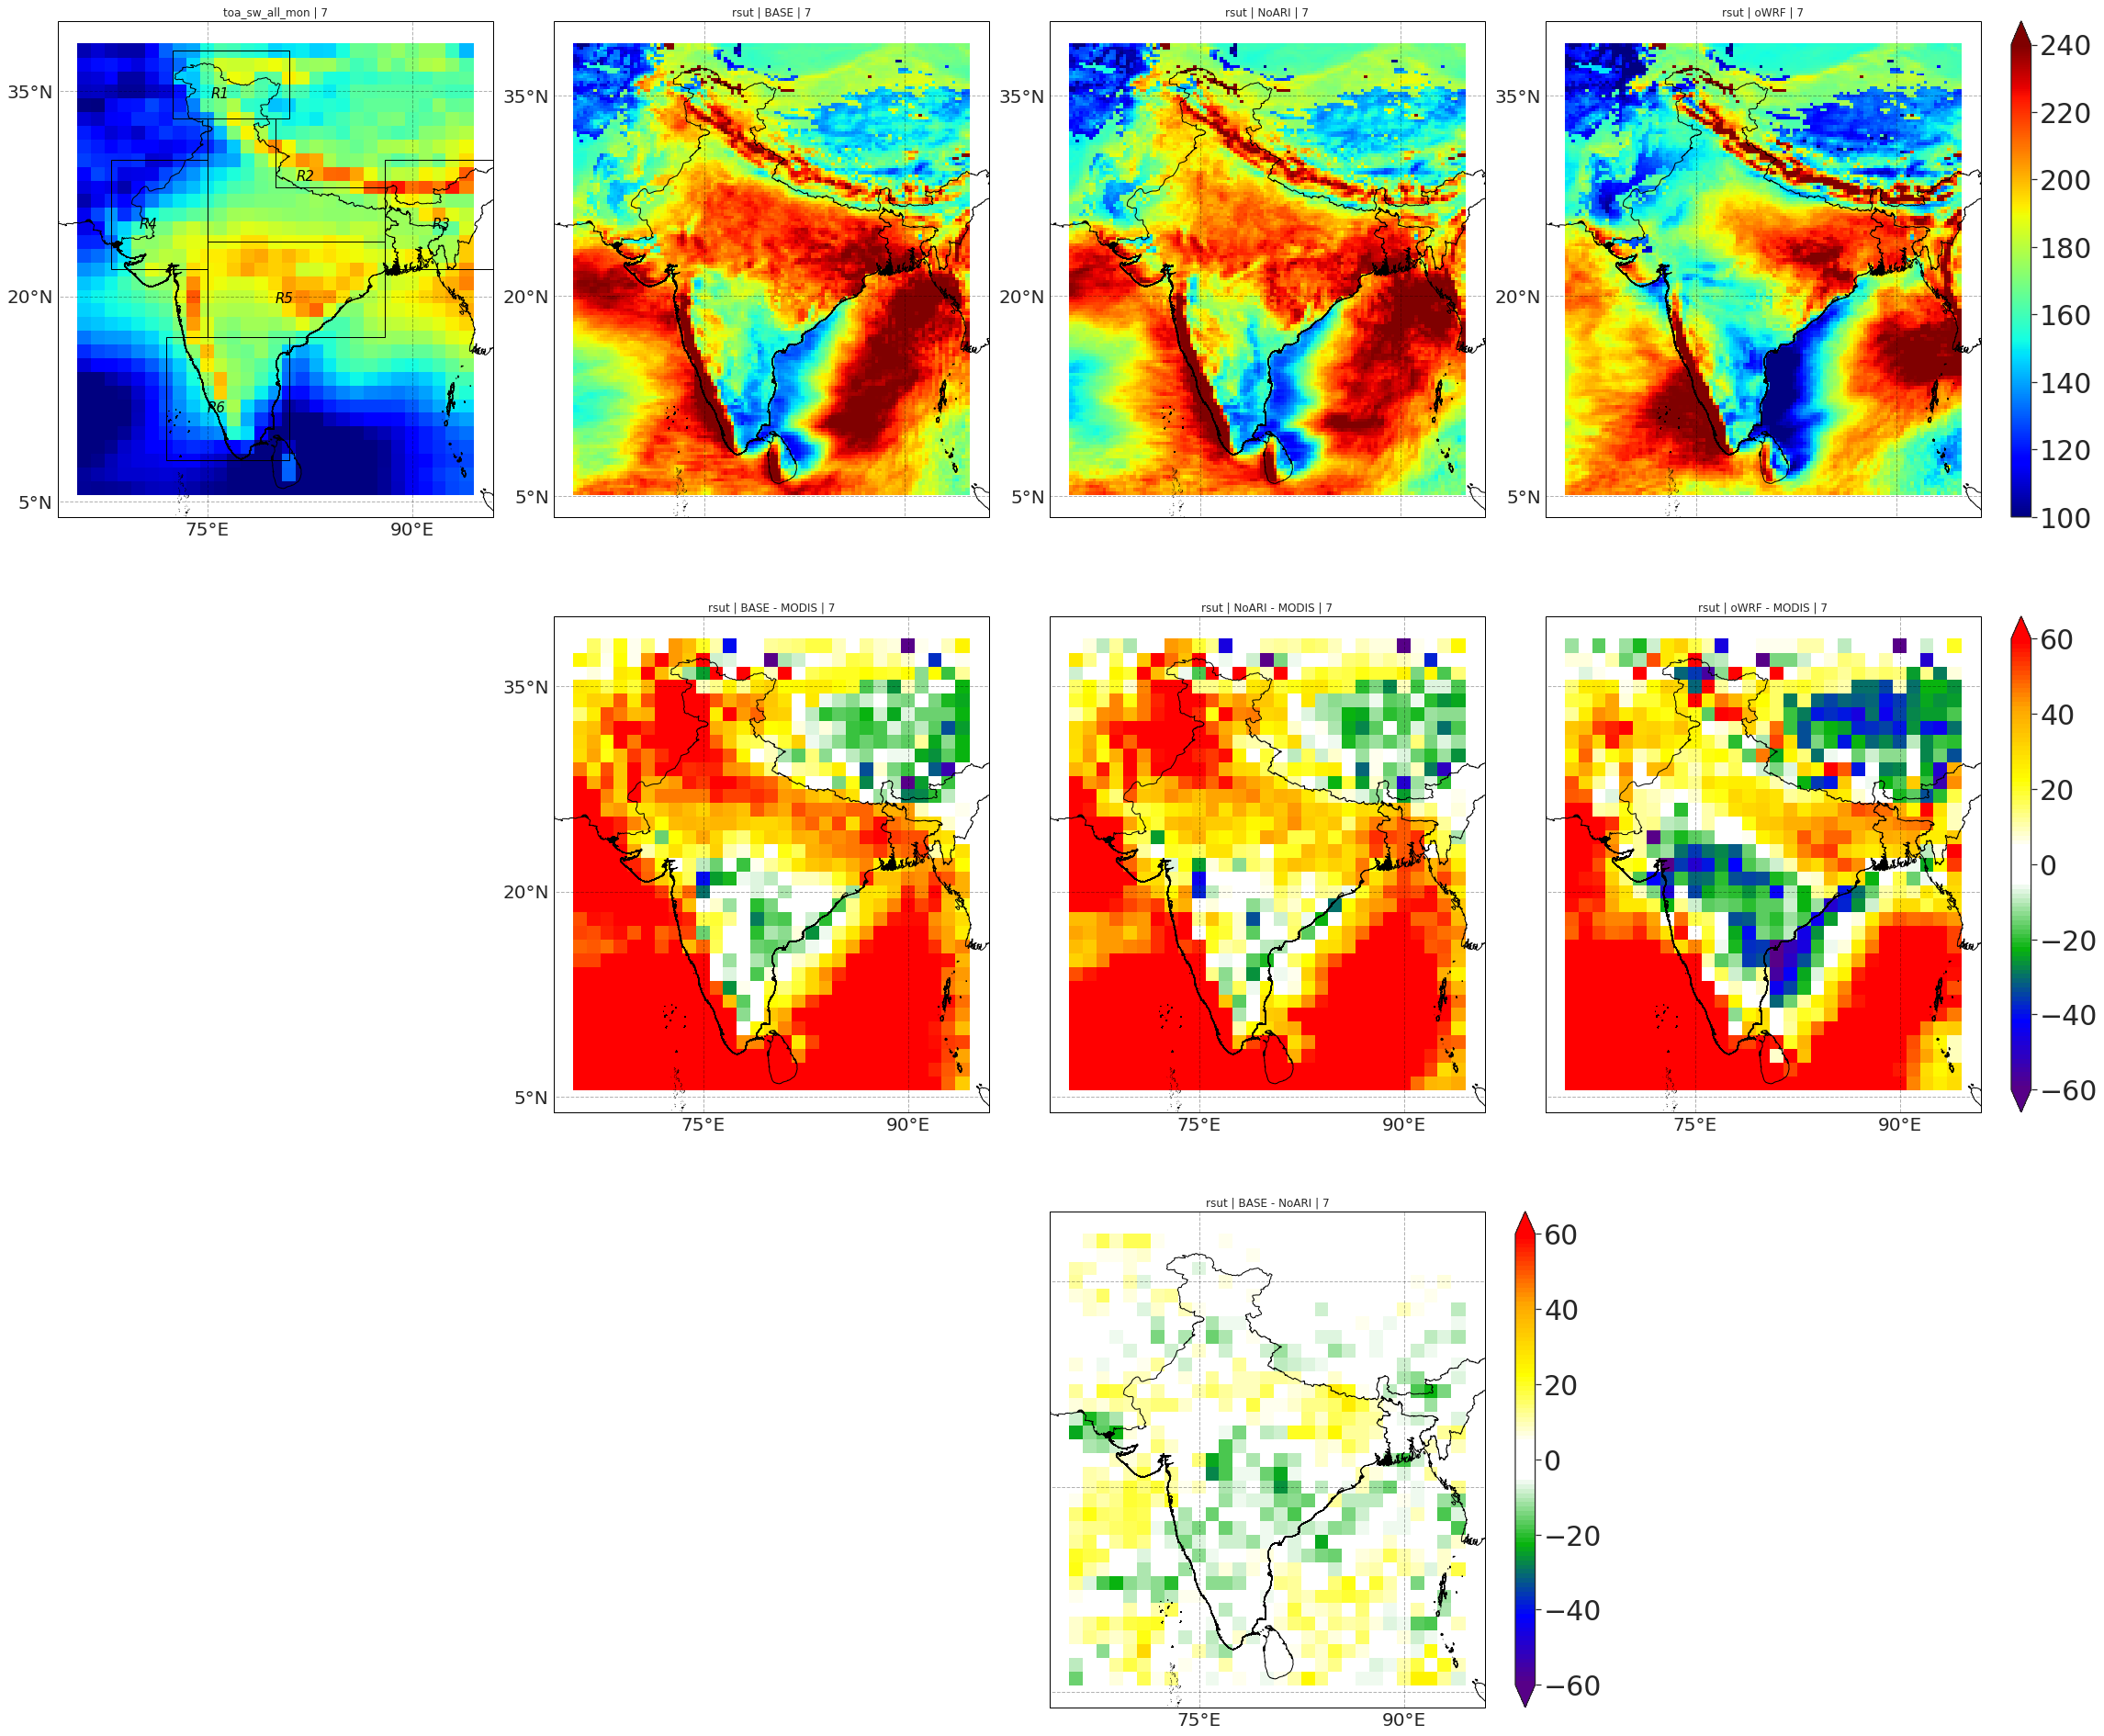

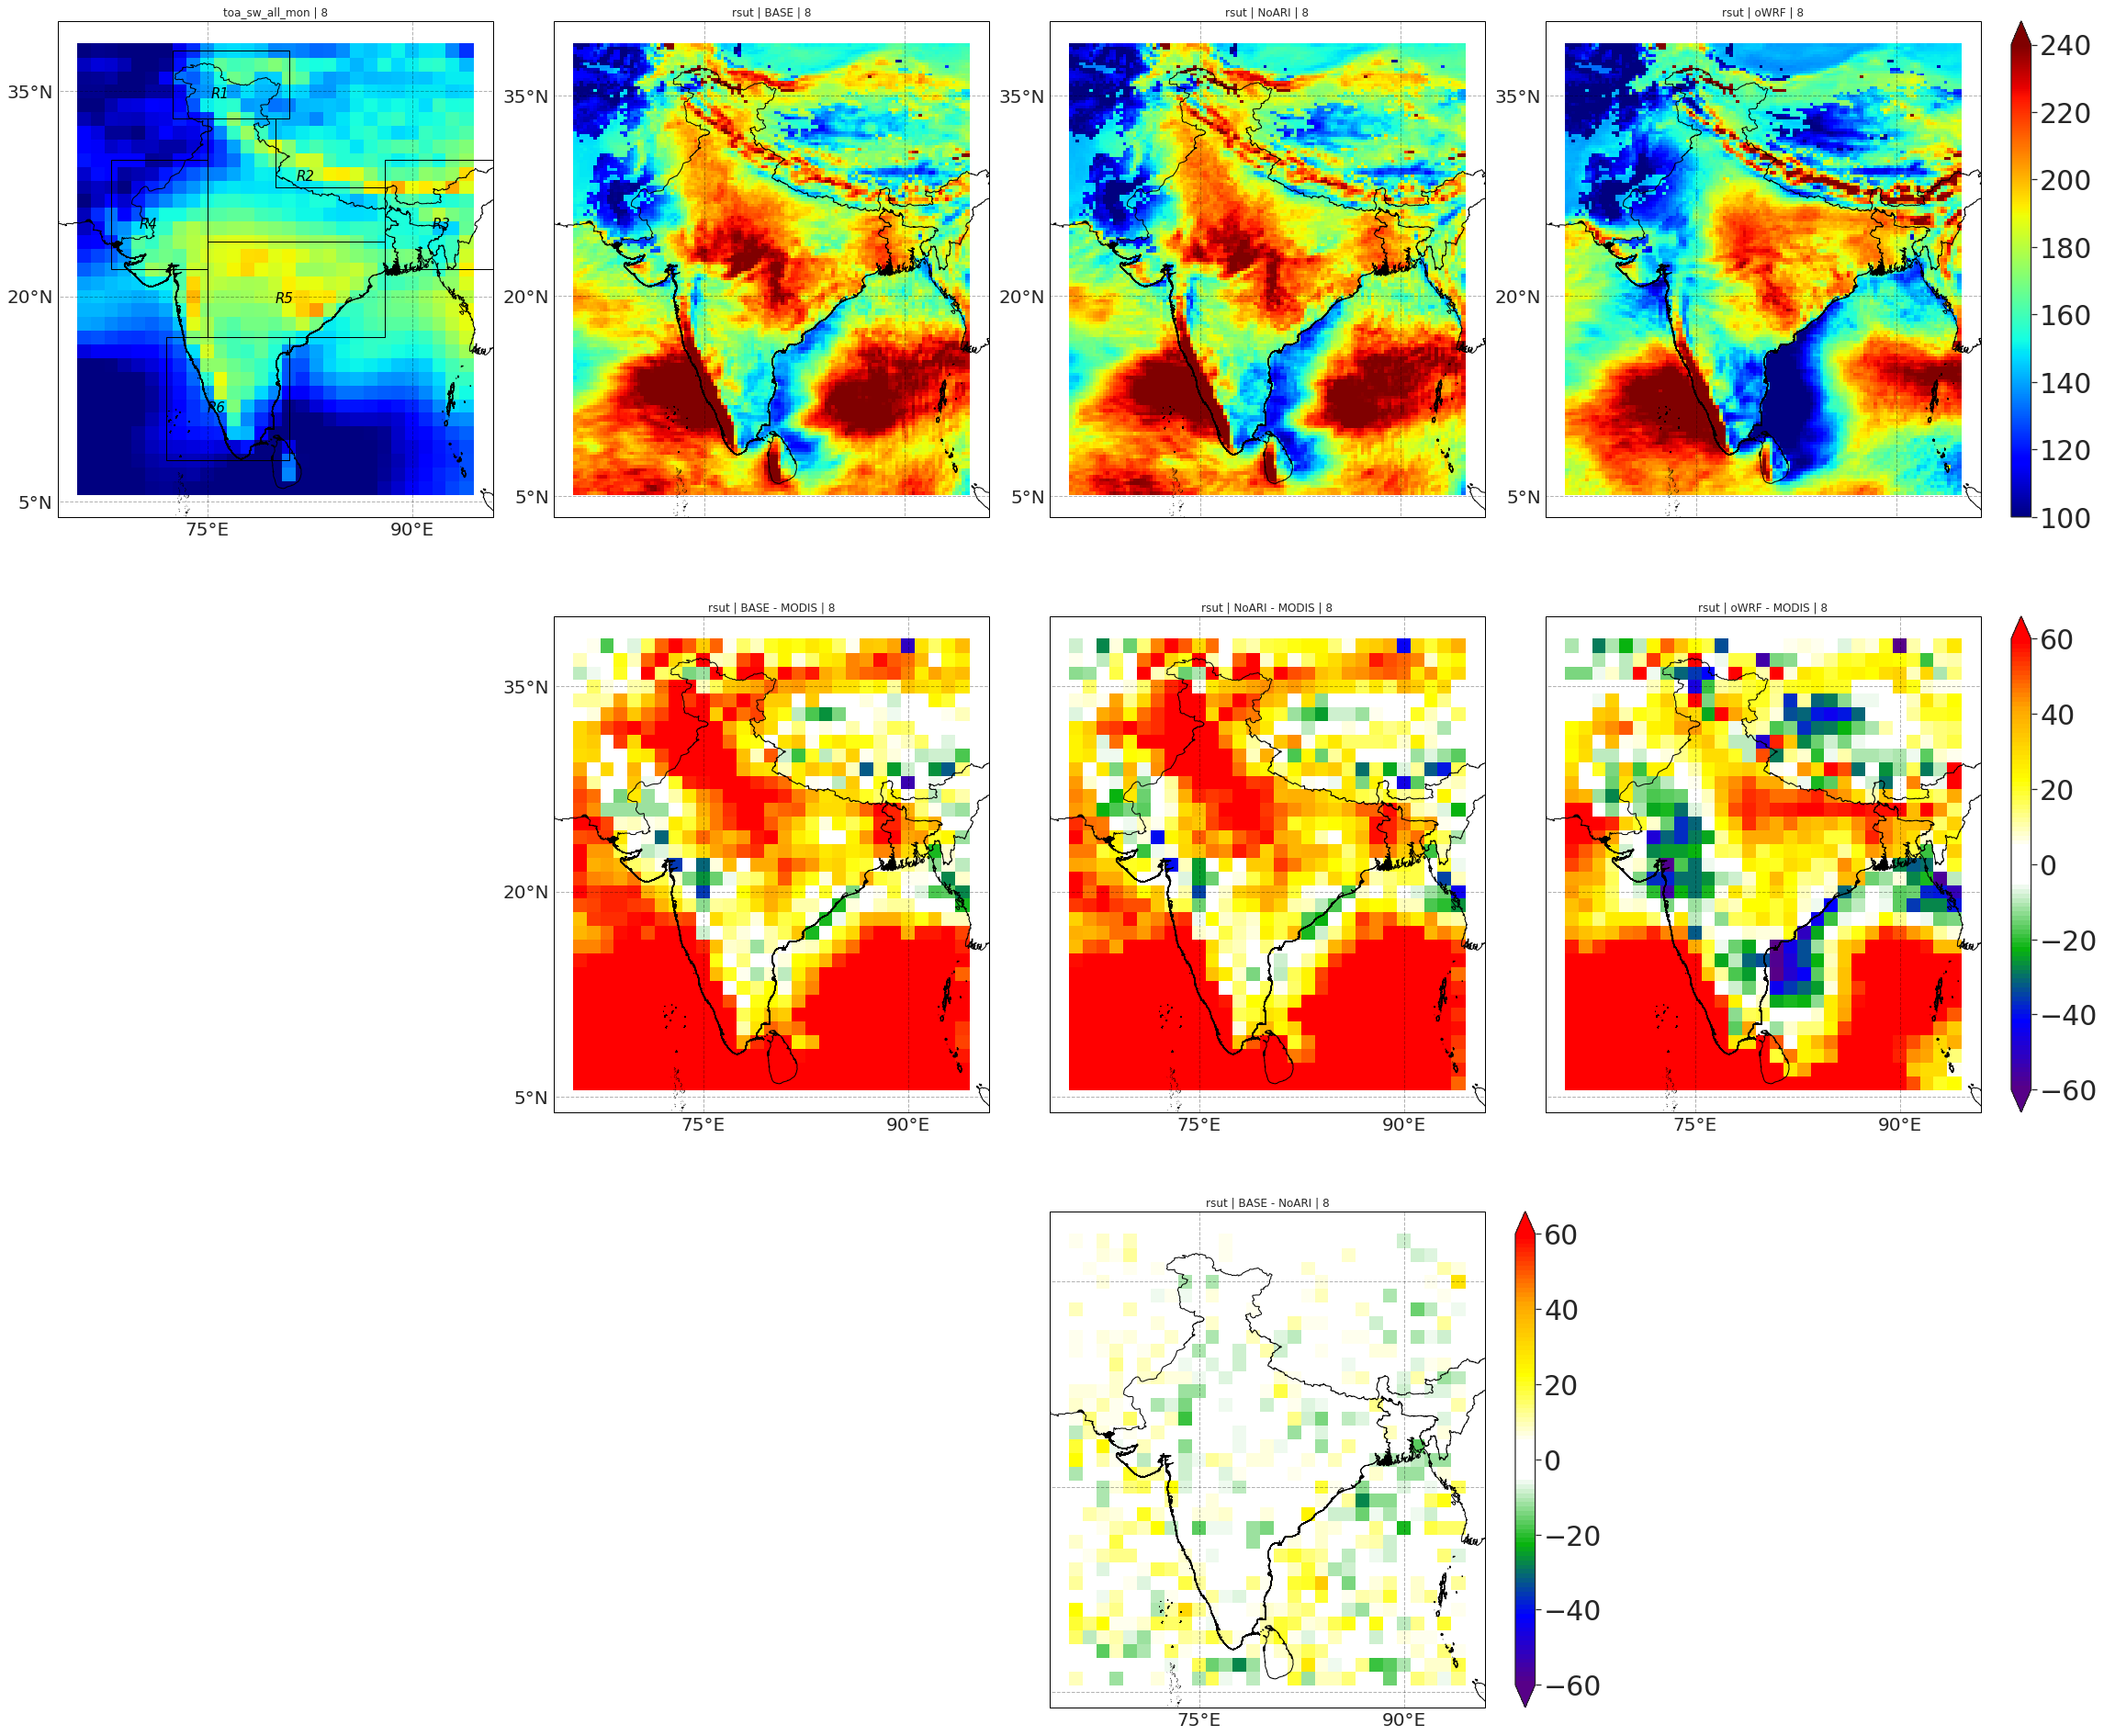

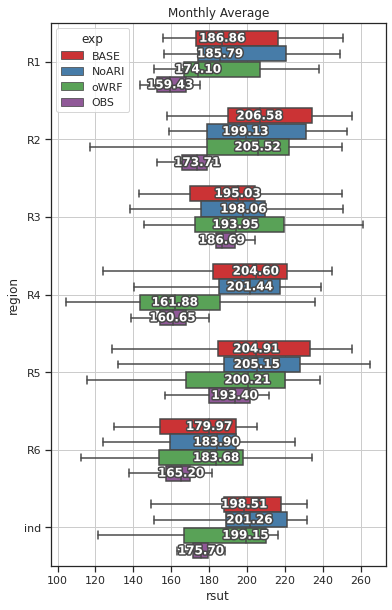

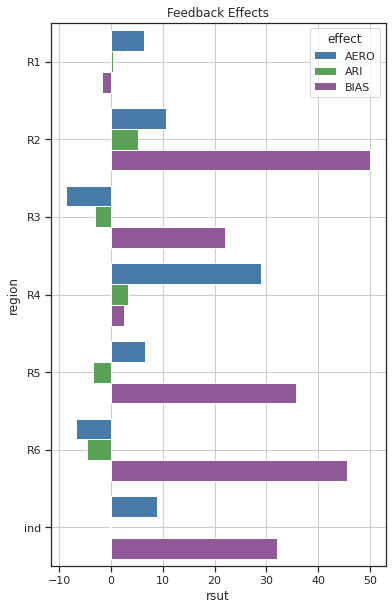

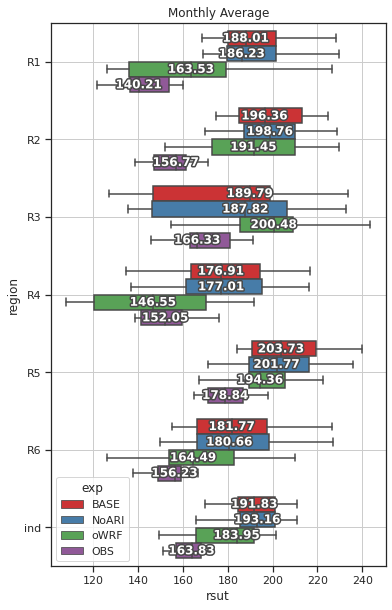

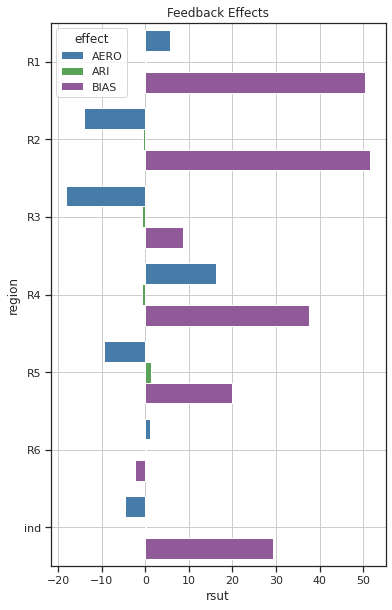

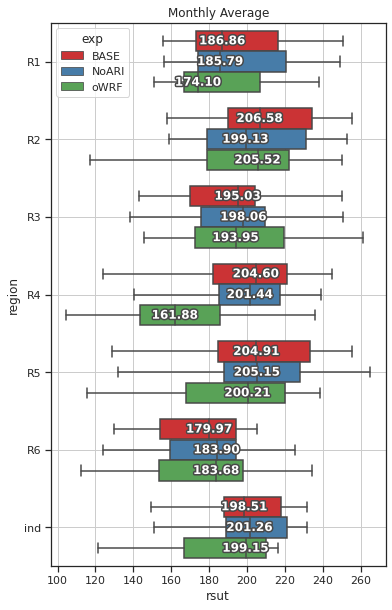

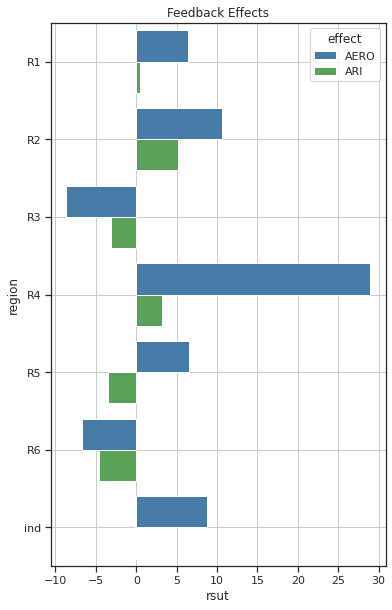

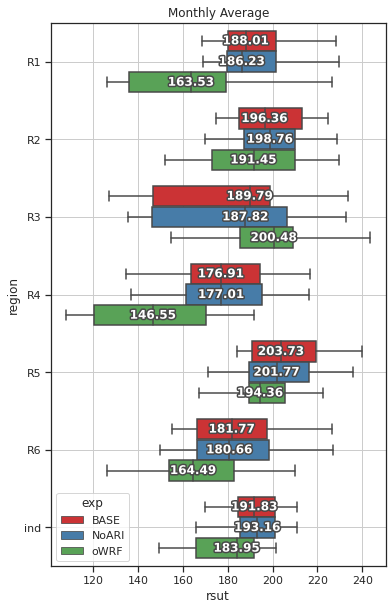

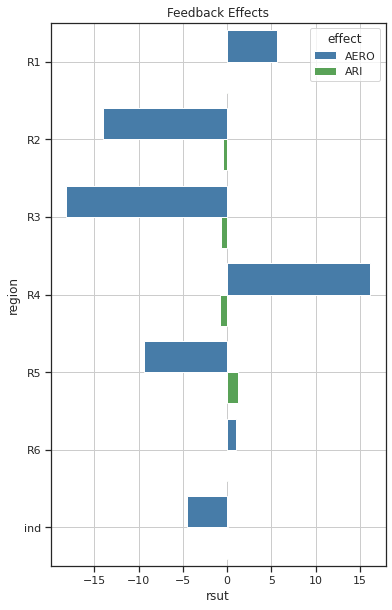

In [41]:
vname_m = 'rsut'
vname_o = 'CERES-SWUP'
scale = 1

dmap = ['BASE','NoARI','oWRF']
dset_WRF = ext_WRF(vname_m,dmap)
dset_OBS = (ext_OBS()[vname_o]).resample(time = '1D').mean()

rmean = [100,240]
rdiff= [-60,60]
panel_difference(dset_WRF,dset_OBS,rmean,rdiff,tp=[7,8])
save_stats(dset_WRF,dset_OBS,[7,8])
pdset_exp,pdset_effect = boxw(dset_WRF,dset_OBS=dset_OBS,dmap=dmap,tp=[7,8])
pdset_exp_nOBS,pdset_effect_nOBS = boxw_nOBS(dset_WRF,dmap=dmap,tp=[7,8])

['/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/pr/gn/pr_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501010100-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/pr/gn/pr_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201507010100-201507300000.nc', '/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/pr/gn/pr_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201508010100-201508200000.nc'] 3
['/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/pr/gn/pr_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/pr/gn/pr_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALES

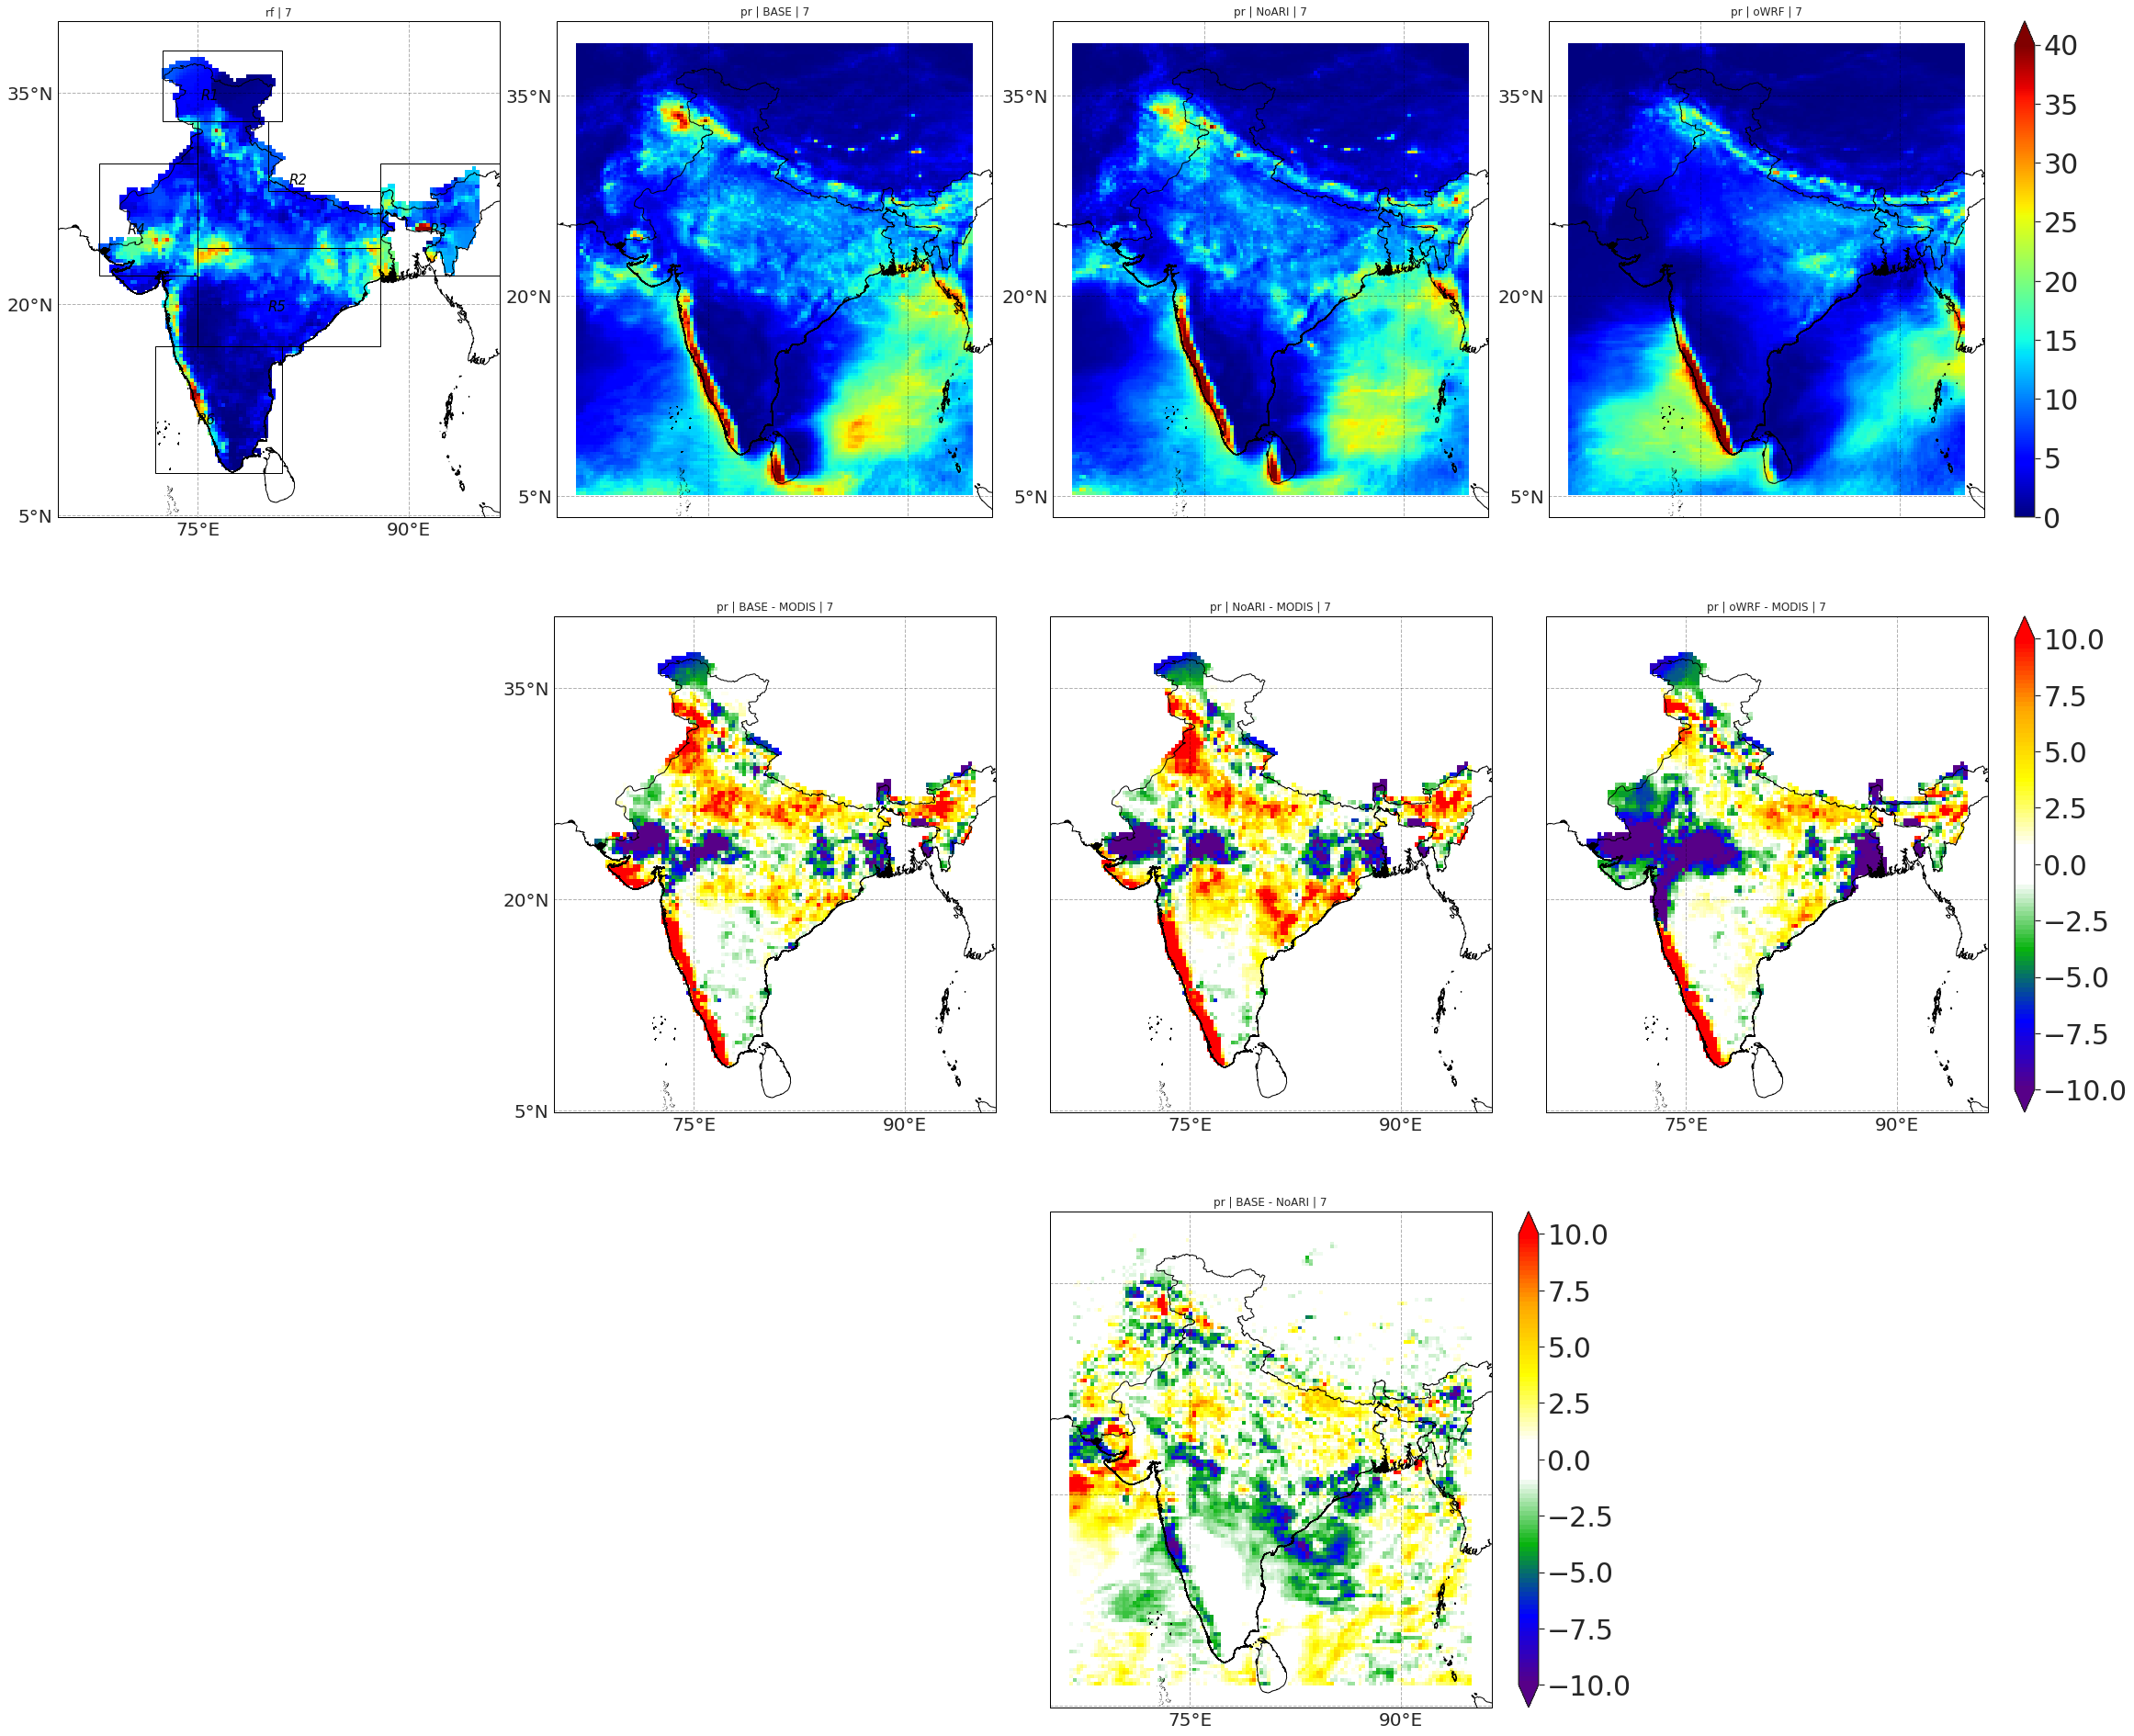

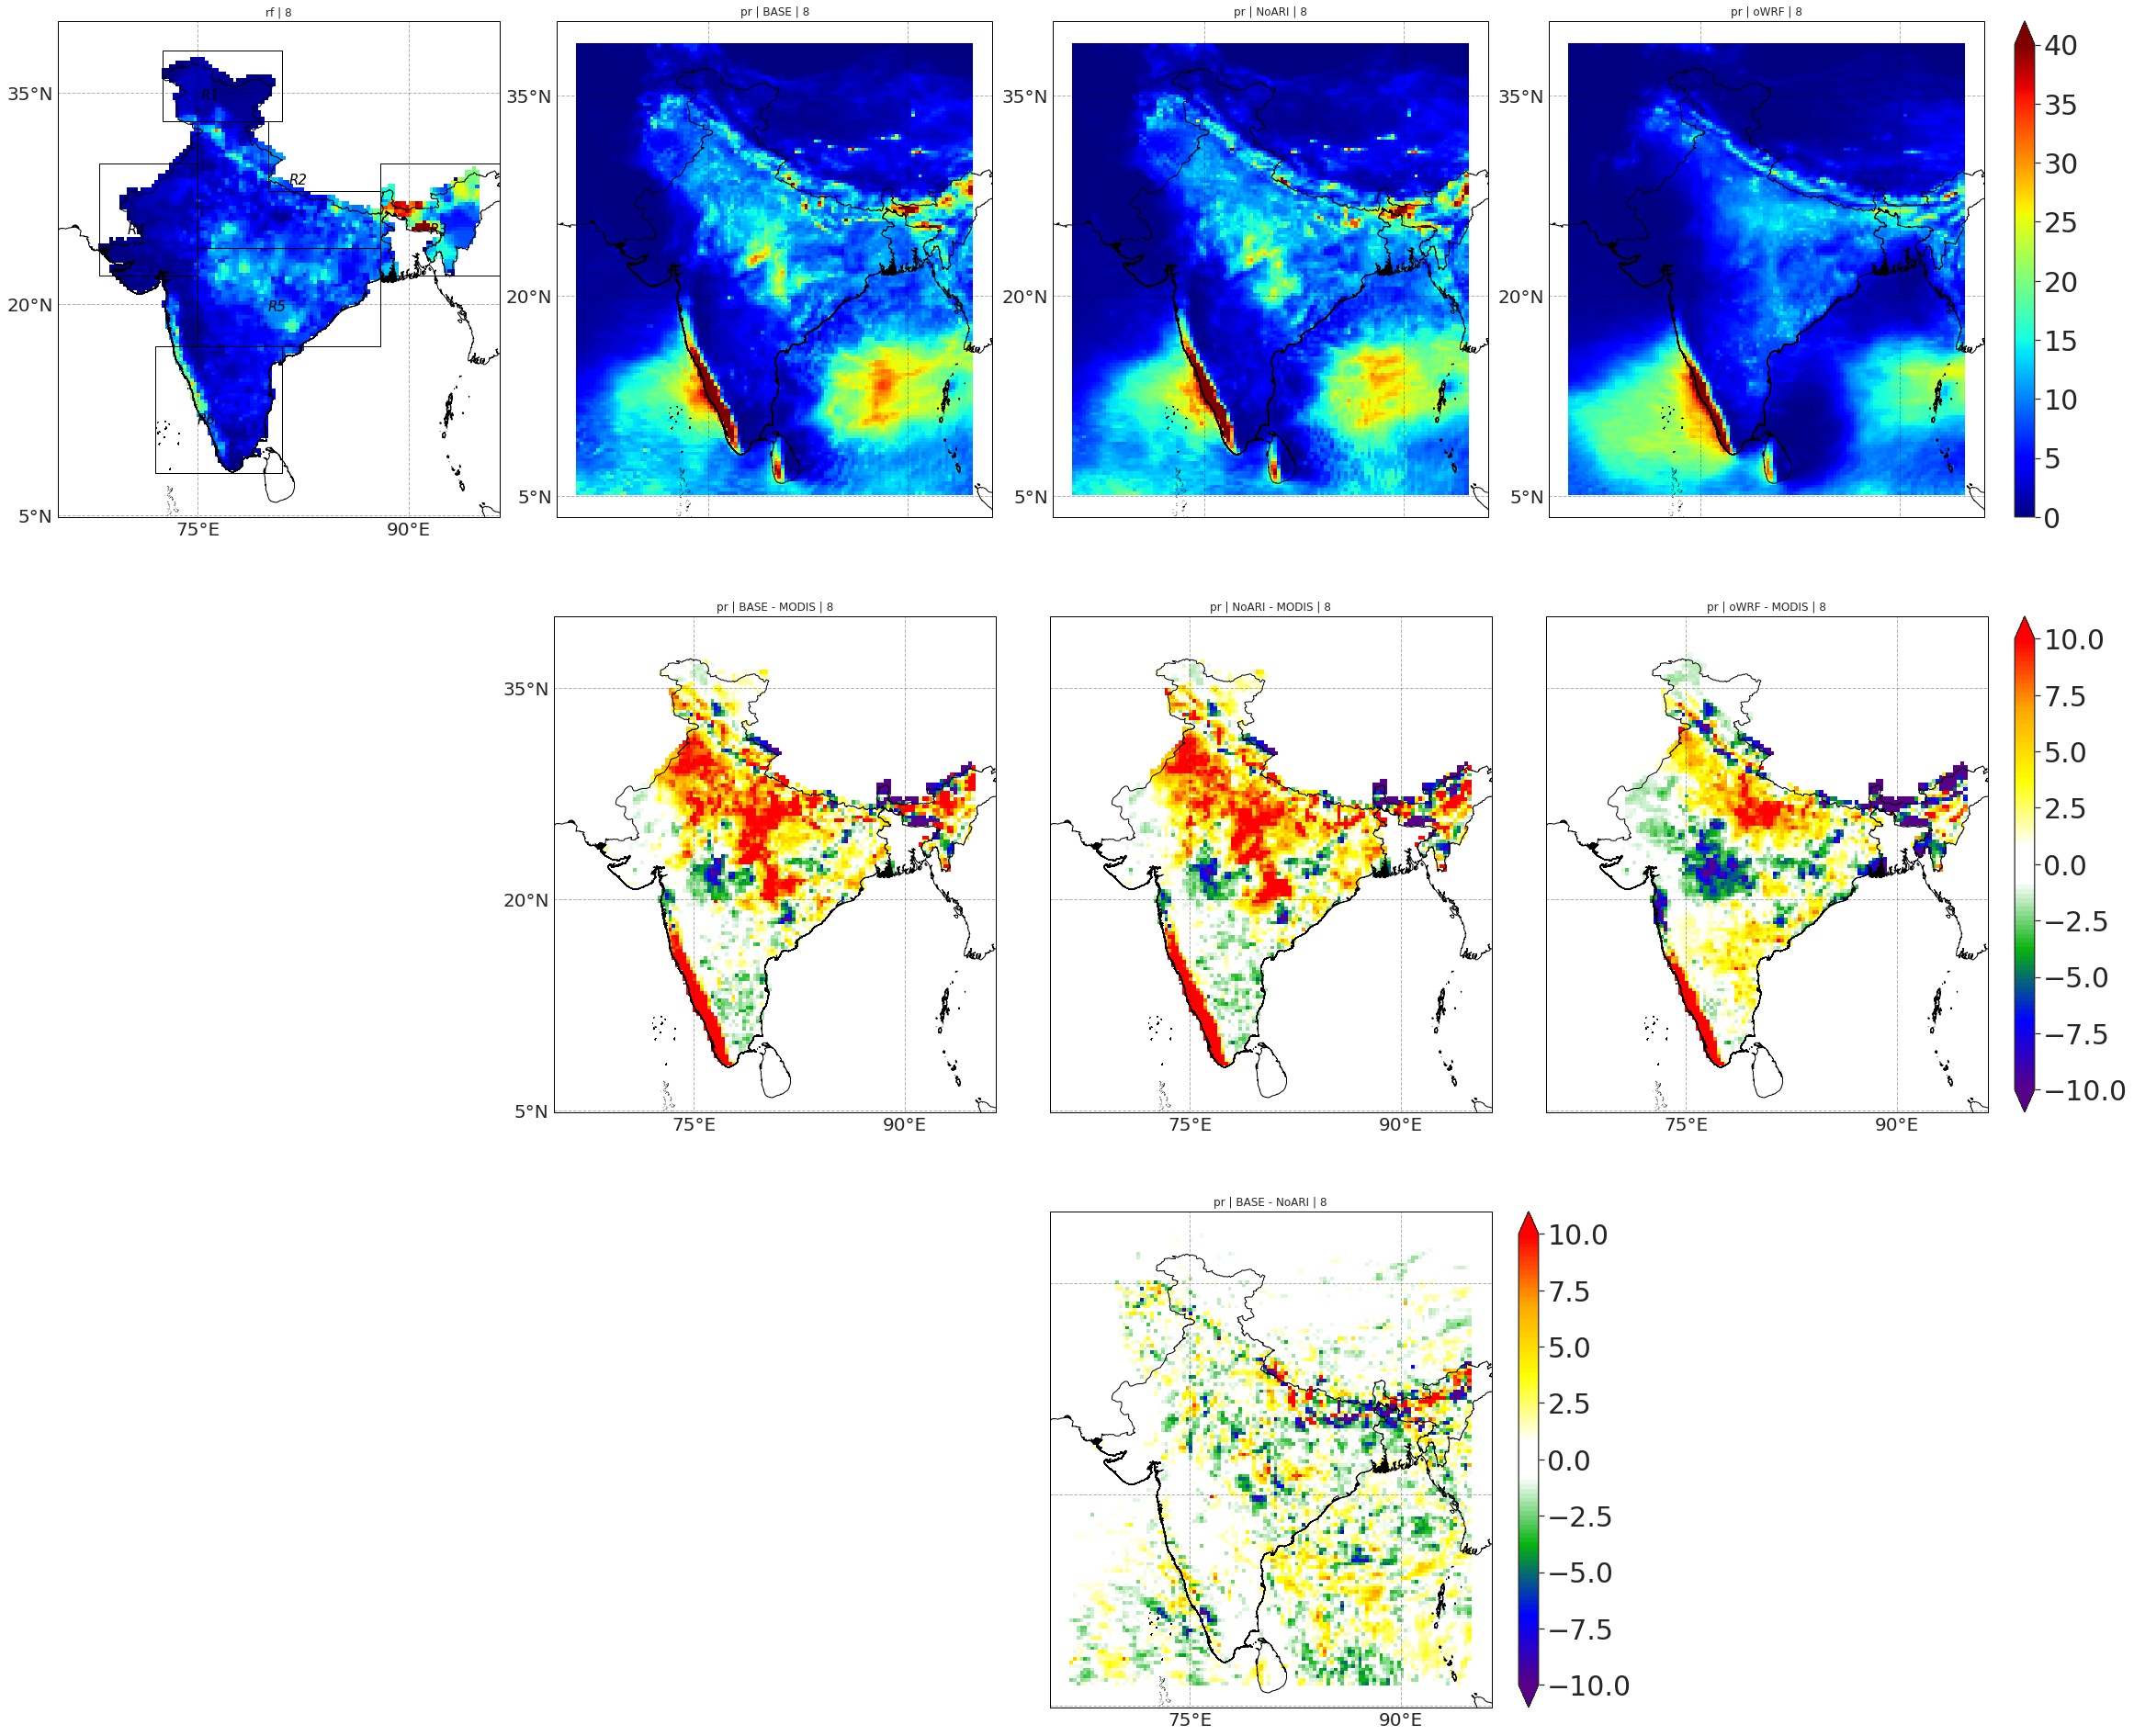

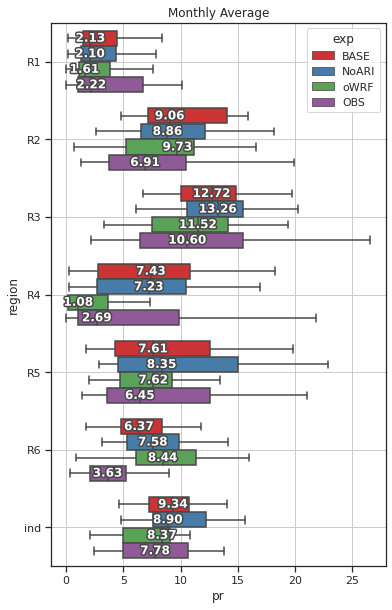

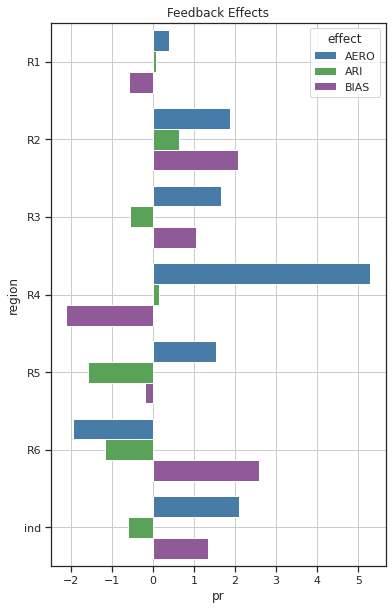

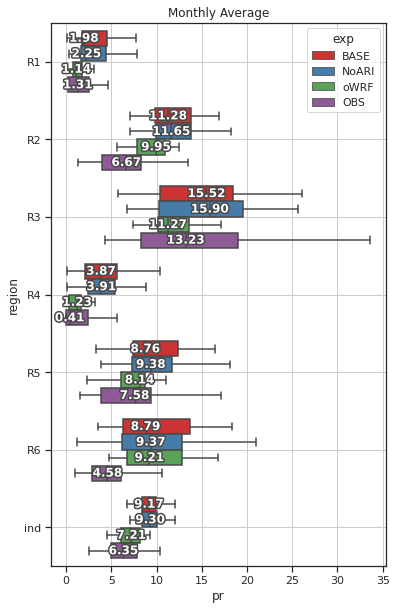

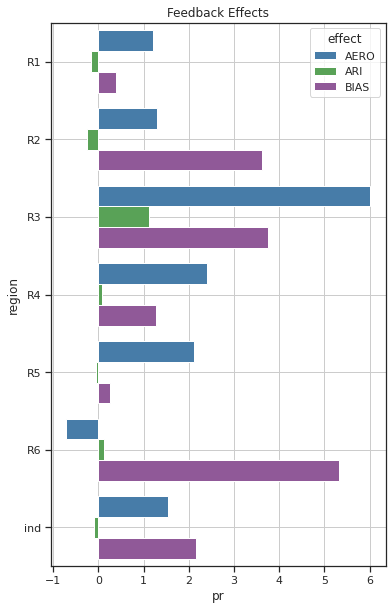

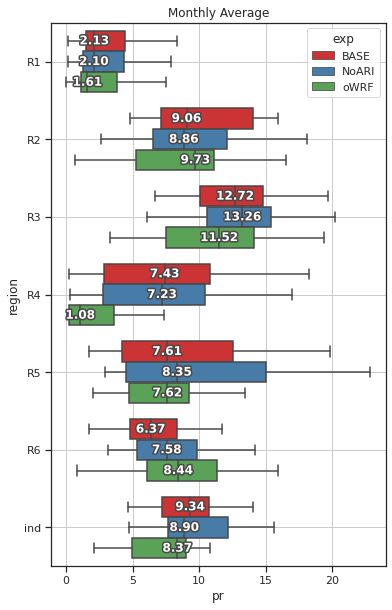

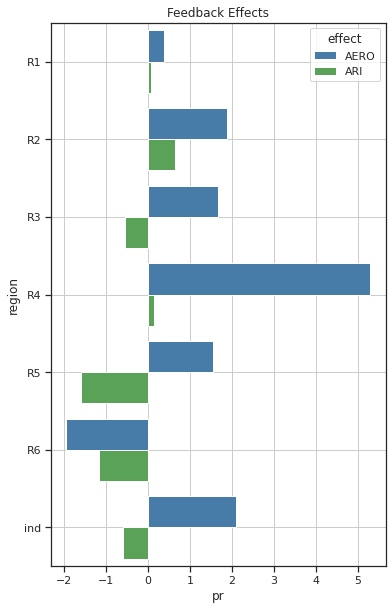

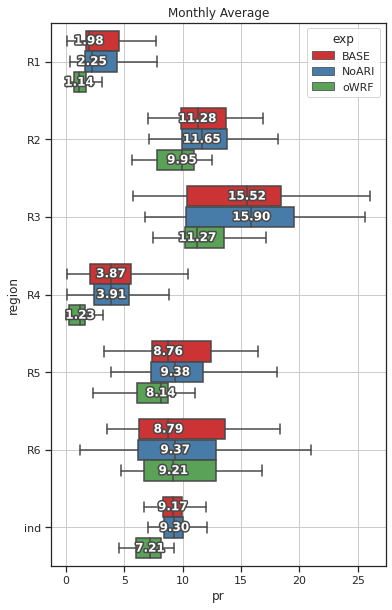

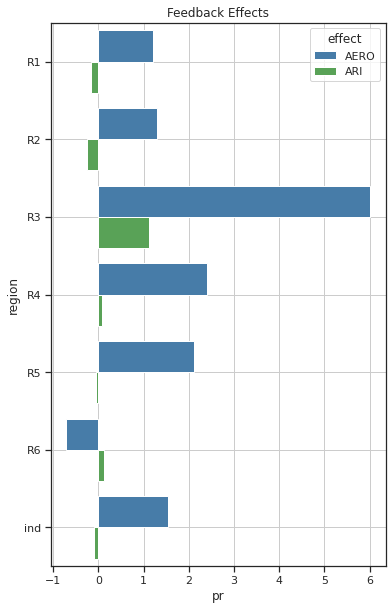

In [42]:
vname_m = 'pr'
vname_o = 'IMD'
scale = 1
dmap = ['BASE','NoARI','oWRF']

dset_WRF = ext_WRF(vname_m,dmap).resample(time = '1D').mean()*86400
dset_OBS = (ext_OBS()[vname_o]).sel(time=dset_WRF.time)#.resample(time = '1D').mean()

rmean = [0,40]
rdiff= [-10,10]

panel_difference(dset_WRF,dset_OBS,rmean,rdiff,tp=[7,8])
save_stats(dset_WRF,dset_OBS,[7,8])
pdset_exp,pdset_effect = boxw(dset_WRF,dset_OBS=dset_OBS,dmap=dmap,tp=[7,8])
pdset_exp_nOBS,pdset_effect_nOBS = boxw_nOBS(dset_WRF,dmap=dmap,tp=[7,8])

['/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/prw/gn/prw_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201507010100-201507300000.nc', '/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/prw/gn/prw_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201508010100-201508200000.nc'] 2
['/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/prw/gn/prw_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501011300-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/prw/gn/prw_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201502010100-201503010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/prw/gn/prw_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201503010100-201504010000.nc', '/mnt/nas/DATA/kaushik/proc/NoARI/NCAP-COALESCE/

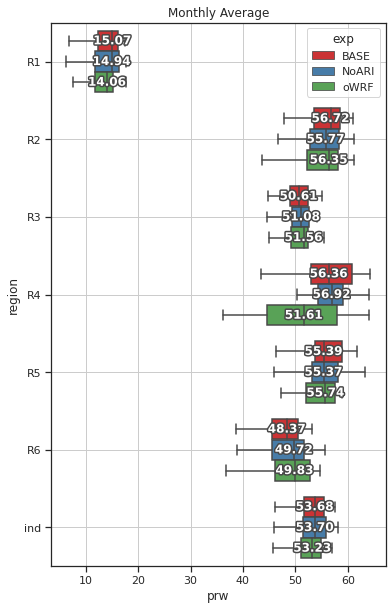

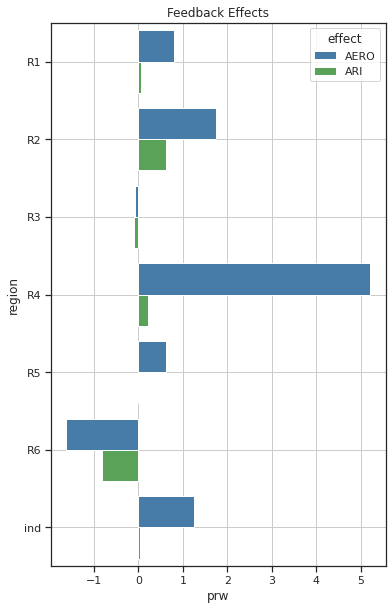

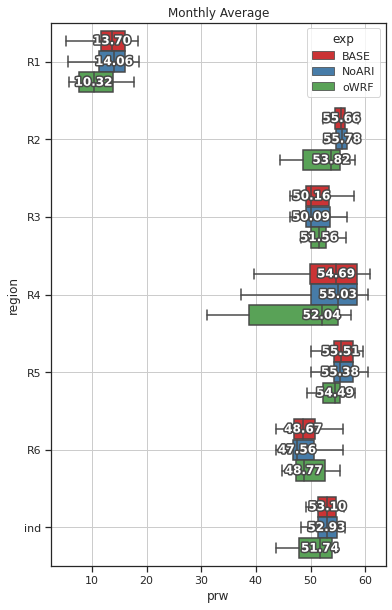

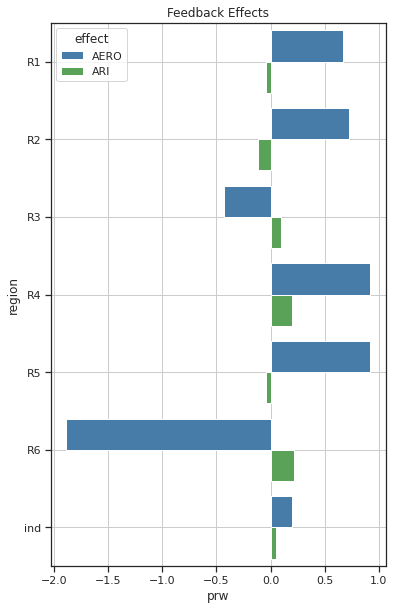

In [44]:
vname_m = 'prw'
vname_o = 'IMD'
scale = 1
dmap = ['BASE','NoARI','oWRF']
dset_WRF = ext_WRF(vname_m,dmap)
pdset_exp_nOBS,pdset_effect_nOBS = boxw_nOBS(dset_WRF,dmap=dmap,tp=[7,8])

#(dset_WRF.sel(exp="BASE") - dset_WRF.sel(exp="NoARI")).sel(time=dset_WRF["time.month"]==7).mean('time').compute().plot(vmin=-1e5,vmax=1e5,cmap="seismic")

In [45]:
dset_WRF

<xarray.DataArray 'prw' (exp: 3, time: 6540, lat: 225, lon: 327)>
dask.array<concatenate, shape=(3, 6540, 225, 327), dtype=float32, chunksize=(1, 2, 225, 327), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T13:00:00 ... 2015-10-01
  * lat      (lat) float64 -12.88 -12.63 -12.38 -12.14 ... 39.32 39.52 39.71
  * lon      (lon) float64 39.02 39.27 39.52 39.77 ... 120.2 120.5 120.7 121.0
  * exp      (exp) object 'BASE' 'NoARI' 'oWRF'
Attributes:
    standard_name:  atmosphere_mass_content_of_water_vapor
    long_name:      Water Vapor Path
    comment:        vertically integrated through the atmospheric column
    units:          kg m-2
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella

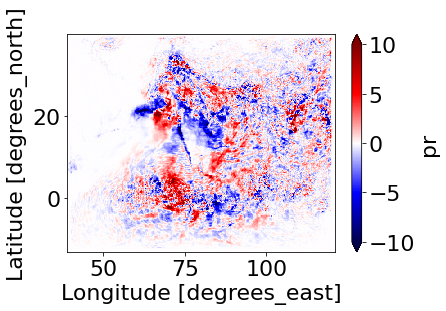

In [26]:
(dset_WRF.sel(exp="BASE") - dset_WRF.sel(exp="NoARI")).sel(time=dset_WRF["time.month"]==7).mean('time').compute().plot(vmin=-10,vmax=10,cmap="seismic")

In [96]:
dset_WRF.isel(exp=1).sel(time=dset_WRF["time.month"]==7).mean('time').compute().plot(vmin=0,vmax=20,cmap="jet")

RuntimeError: NetCDF: HDF error

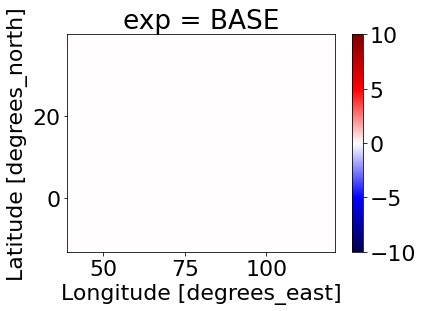

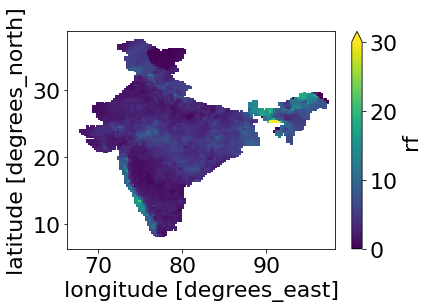

In [31]:
plt.figure()
(dset_WRF.isel(exp=0) - dset_WRF.isel(exp=1).data).sel(time=dset_WRF["time.month"]==7).mean('time').plot(vmin=-10,vmax=10,cmap="seismic")
plt.figure()
dset_OBS.mean('time').plot(vmin=0,vmax=30)

In [20]:
dset_WRF

<xarray.DataArray 'time' (time: 173)>
array(['2015-03-01T00:00:00.000000000', '2015-03-02T00:00:00.000000000',
       '2015-03-03T00:00:00.000000000', '2015-03-04T00:00:00.000000000',
       '2015-03-05T00:00:00.000000000', '2015-03-06T00:00:00.000000000',
       '2015-03-07T00:00:00.000000000', '2015-03-08T00:00:00.000000000',
       '2015-03-09T00:00:00.000000000', '2015-03-10T00:00:00.000000000',
       '2015-03-11T00:00:00.000000000', '2015-03-12T00:00:00.000000000',
       '2015-03-13T00:00:00.000000000', '2015-03-14T00:00:00.000000000',
       '2015-03-15T00:00:00.000000000', '2015-03-16T00:00:00.000000000',
       '2015-03-17T00:00:00.000000000', '2015-03-18T00:00:00.000000000',
       '2015-03-19T00:00:00.000000000', '2015-03-20T00:00:00.000000000',
       '2015-03-21T00:00:00.000000000', '2015-03-22T00:00:00.000000000',
       '2015-03-23T00:00:00.000000000', '2015-03-24T00:00:00.000000000',
       '2015-03-25T00:00:00.000000000', '2015-03-26T00:00:00.000000000',
       '2015-03-27T00:00:00.000000000', '2015-03-28T00:00:00.000000000',
       '2015-03-29T00:00:00.000000000', '2015-03-30T00:00:00.000000000',
       '2015-03-31T00:00:00.000000000', '2015-04-01T00:00:00.000000000',
       '2015-04-02T00:00:00.000000000', '2015-04-03T00:00:00.000000000',
       '2015-04-04T00:00:00.000000000', '2015-04-05T00:00:00.000000000',
       '2015-04-06T00:00:00.000000000', '2015-04-07T00:00:00.000000000',
       '2015-04-08T00:00:00.000000000', '2015-04-09T00:00:00.000000000',
       '2015-04-10T00:00:00.000000000', '2015-04-11T00:00:00.000000000',
       '2015-04-12T00:00:00.000000000', '2015-04-13T00:00:00.000000000',
       '2015-04-14T00:00:00.000000000', '2015-04-15T00:00:00.000000000',
       '2015-04-16T00:00:00.000000000', '2015-04-17T00:00:00.000000000',
       '2015-04-18T00:00:00.000000000', '2015-04-19T00:00:00.000000000',
       '2015-04-20T00:00:00.000000000', '2015-04-21T00:00:00.000000000',
       '2015-04-22T00:00:00.000000000', '2015-04-23T00:00:00.000000000',
       '2015-04-24T00:00:00.000000000', '2015-04-25T00:00:00.000000000',
       '2015-04-26T00:00:00.000000000', '2015-04-27T00:00:00.000000000',
       '2015-04-28T00:00:00.000000000', '2015-04-29T00:00:00.000000000',
       '2015-04-30T00:00:00.000000000', '2015-05-01T00:00:00.000000000',
       '2015-05-02T00:00:00.000000000', '2015-05-03T00:00:00.000000000',
       '2015-05-04T00:00:00.000000000', '2015-05-05T00:00:00.000000000',
       '2015-05-06T00:00:00.000000000', '2015-05-07T00:00:00.000000000',
       '2015-05-08T00:00:00.000000000', '2015-05-09T00:00:00.000000000',
       '2015-05-10T00:00:00.000000000', '2015-05-11T00:00:00.000000000',
       '2015-05-12T00:00:00.000000000', '2015-05-13T00:00:00.000000000',
       '2015-05-14T00:00:00.000000000', '2015-05-15T00:00:00.000000000',
       '2015-05-16T00:00:00.000000000', '2015-05-17T00:00:00.000000000',
       '2015-05-18T00:00:00.000000000', '2015-05-19T00:00:00.000000000',
       '2015-05-20T00:00:00.000000000', '2015-05-21T00:00:00.000000000',
       '2015-05-22T00:00:00.000000000', '2015-05-23T00:00:00.000000000',
       '2015-05-24T00:00:00.000000000', '2015-05-25T00:00:00.000000000',
       '2015-05-26T00:00:00.000000000', '2015-05-27T00:00:00.000000000',
       '2015-05-28T00:00:00.000000000', '2015-05-29T00:00:00.000000000',
       '2015-05-30T00:00:00.000000000', '2015-05-31T00:00:00.000000000',
       '2015-06-01T00:00:00.000000000', '2015-06-02T00:00:00.000000000',
       '2015-06-03T00:00:00.000000000', '2015-06-04T00:00:00.000000000',
       '2015-06-05T00:00:00.000000000', '2015-06-06T00:00:00.000000000',
       '2015-06-07T00:00:00.000000000', '2015-06-08T00:00:00.000000000',
       '2015-06-09T00:00:00.000000000', '2015-06-10T00:00:00.000000000',
       '2015-06-11T00:00:00.000000000', '2015-06-12T00:00:00.000000000',
       '2015-06-13T00:00:00.000000000', '2015-06-14T00:00:00.000000000',
       '2015-06-15T00:00:00.000000000', '2015-06-16T00:00:00.000000000',
       '2015-06-17T0

[########################################] | 100% Completed |  1.4s
[250, 300]
[250, 300]
[-5, 5]


IndexError: list index out of range

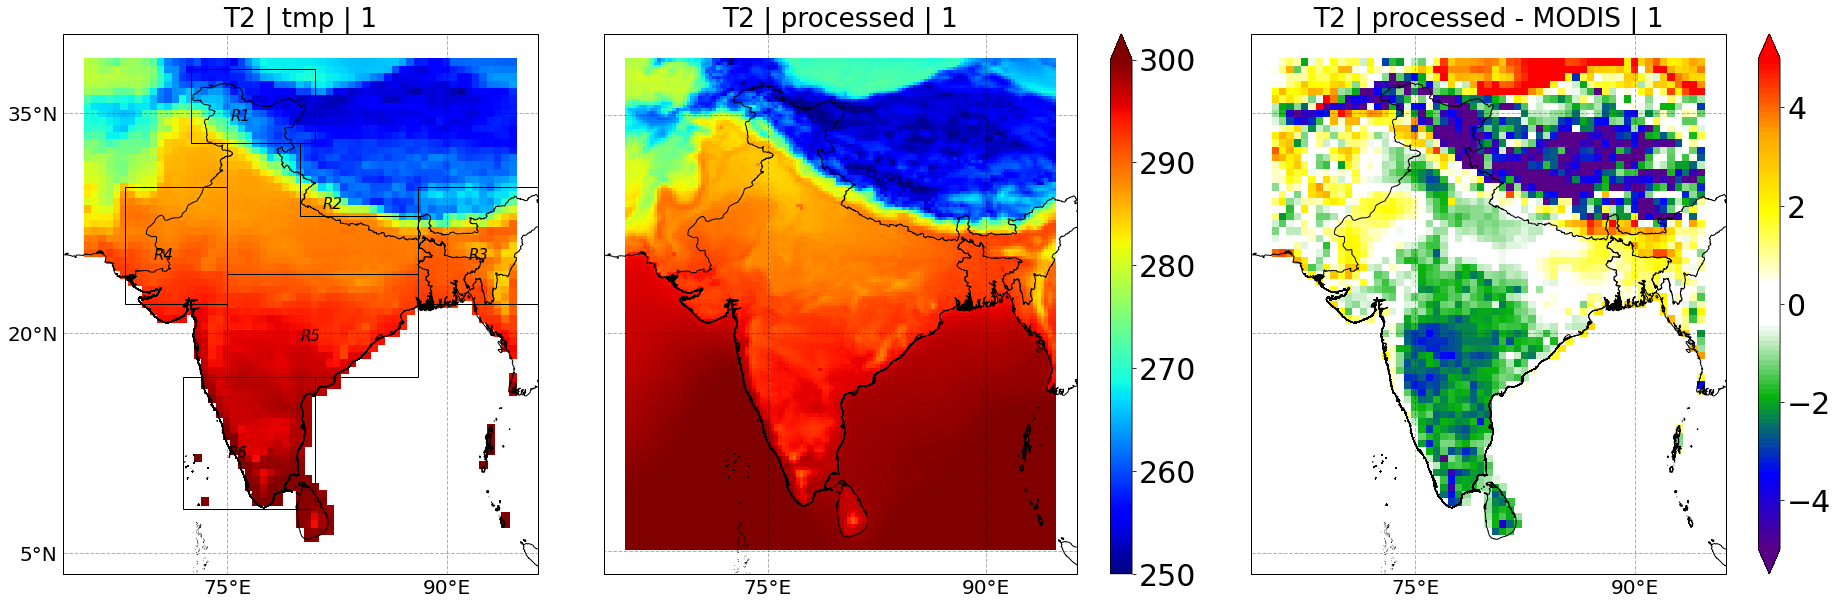

In [28]:
vname_m = 'tas'
vname_o = 'CRU-T'
scale = 1
dmap = ['processed']

dset_WRF = ext_WRF(vname_m,dmap)
dset_OBS = (ext_OBS()[vname_o]).resample(time = '1D').mean()


validation('T2',1,dset_OBS,dset_WRF,[250,300],[-5,5])


for exp in range(2):
    with pd.ExcelWriter(vname_m+'_'+dmap[exp]+'.xlsx') as writer:
        for reg in ['R1','R2','R3','R4','R5','R6','ind']:
            sts = {}
            for mon in range(1,7,1):
                x = calc_stats(dset_WRF.isel(exp=exp),dset_OBS.sel(time = dset_OBS['time.year']==2015),region=reg,tperiod=mon,obs_name=vname_o,scale=scale)
                sts[mon] = x
            sts = pd.DataFrame(sts).T
            sts.to_excel(writer,sheet_name=reg)
            
            
vname_m = 'tas'
vname_o = 'CRU-T'
scale = 1
dset_WRF = ext_CBMZ(vname_m)
dset_OBS = (ext_OBS()[vname_o]).resample(time = '1D').mean()

with pd.ExcelWriter(vname_m+'_'+'CBMZ'+'.xlsx') as writer:
    for reg in ['R1','R2','R3','R4','R5','R6','ind']:
        sts = {}
        for mon in range(1,13,1):
            x = calc_stats(dset_WRF,dset_OBS.sel(time = dset_OBS['time.year']==2015),region=reg,tperiod=mon,obs_name=vname_o,scale=scale)
            sts[mon] = x
        sts = pd.DataFrame(sts).T
        sts.to_excel(writer,sheet_name=reg)

In [14]:
vname_m = 'zmla'
vname_o = 'PBLH'
scale = 1
dmap = ['BASE','oWRF']

dset_WRF = ext_WRF(vname_m,dmap)
dset_OBS = (ext_OBS()[vname_o])

#save_stats(dset_WRF,dset_OBS,[7,8])

#rmean = [100,1500]
#rdiff= [-200,200]
#panel_difference(dset_WRF,dset_OBS,rmean,rdiff,tp=[7,8])


['/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/zmla/gn/zmla_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201507010100-201507300000.nc', '/mnt/nas/DATA/kaushik/proc/BASE/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/zmla/gn/zmla_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201508010100-201508200000.nc'] 2
['/mnt/nas/DATA/kaushik/proc/oWRF/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/zmla/gn/zmla_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201501010100-201502010000.nc', '/mnt/nas/DATA/kaushik/proc/oWRF/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/zmla/gn/zmla_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201506010100-201507010000.nc', '/mnt/nas/DATA/kaushik/proc/oWRF/NCAP-COALESCE/NCAP-COALESCE/IIT-Bombay/IITB-WRF_Chem/BASELINE/r1i1p1f1/1hr/zmla/gn/zmla_1hr_IITB-WRF_Chem_BASELINE_r1i1p1f1_gn_201507010100-201508010000.nc', '/mnt/nas/DATA/kaushik/proc/oWRF/NCAP-COA

(array([735780., 735784., 735788., 735792., 735796., 735800., 735804.,
        735808.]),
 <a list of 8 Text major ticklabel objects>)

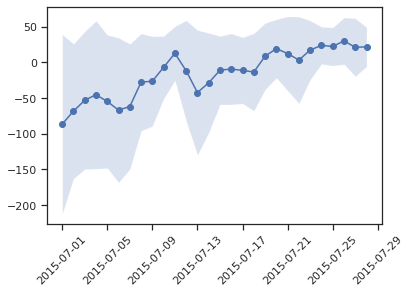

In [36]:
mean_month = regionX(dset_WRF.sel(time=slice('2015-07-01','2015-07-28')),'ind').resample(time="1D").mean()
std_month = regionX(dset_WRF.sel(time=slice('2015-07-01','2015-07-28')),'ind').resample(time="1D").std()

aero_mean = (mean_month.mean(["lat","lon"]).sel(exp="BASE") - mean_month.mean(["lat","lon"]).sel(exp="oWRF")).compute()
aero_std = (std_month.mean(["lat","lon"]).sel(exp="BASE") - std_month.mean(["lat","lon"]).sel(exp="oWRF")).compute()

plt.plot(aero_mean.time.data, aero_mean,marker='o')
#plt.fill_between(aero_mean.time.data, aero_mean+aero_std,aero_mean-aero_std,alpha=0.2)
plt.xticks(rotation=45)

In [27]:
aero_mean.time.data

array(['2015-07-31T00:00:00.000000000', '2015-08-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [13]:
vname_m = 'rsds'
vname_o = 'CERES-SWDN'
scale = -1
dmap = ["processed","NoARI"]
dset_WRF = ext_WRF(vname_m,dmap)
dset_OBS = (ext_OBS()[vname_o]).resample(time = '1D').mean()
for exp in range(len(dmap)):
    with pd.ExcelWriter(vname_m+'_'+dmap[exp]+'.xlsx') as writer:
        for reg in ['R1','R2','R3','R4','R5','R6','ind']:
            sts = {}
            for mon in [1]:#range(1,7,1):
                x = calc_stats(dset_WRF.isel(exp=exp),dset_OBS.sel(time = dset_OBS['time.year']==2015),region=reg,tperiod=mon,obs_name=vname_o,scale=scale)
                sts[mon] = x
            sts = pd.DataFrame(sts).T
            sts.to_excel(writer,sheet_name=reg)
            
vname_m = 'rlut'
vname_o = 'CERES-OLR'
scale = 1

dset_WRF = ext_WRF(vname_m,dmap)
dset_OBS = (ext_OBS()[vname_o]).resample(time = '1D').mean()
for exp in range(len(dmap)):
    with pd.ExcelWriter(vname_m+'_'+dmap[exp]+'.xlsx') as writer:
        for reg in ['R1','R2','R3','R4','R5','R6','ind']:
            sts = {}
            for mon in [1]:#range(1,7,1):
                x = calc_stats(dset_WRF.isel(exp=exp),dset_OBS.sel(time = dset_OBS['time.year']==2015),region=reg,tperiod=mon,obs_name=vname_o,scale=scale)
                sts[mon] = x
            sts = pd.DataFrame(sts).T
            sts.to_excel(writer,sheet_name=reg)

ValueError: must supply at least one object to concatenate

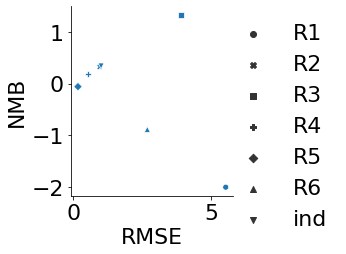

In [45]:
stats_dset = pd.concat([pd.read_excel('tas_processed.xlsx',sheet_name=reg).loc[3] for reg in ['R1','R2','R3','R4','R5','R6','ind']],axis=1,keys=['R1','R2','R3','R4','R5','R6','ind'])

import seaborn as sns
sns.relplot(x="RMSE", y="NMB", style=stats_dset.columns,
            sizes=(40, 400), alpha=1,
            height=4,data=stats_dset.T)#, size="weight", palette="muted",

In [48]:
stats_dset = pd.concat([pd.read_excel('od550aer_processed.xlsx',sheet_name=reg).loc[1] for reg in ['R1','R2','R3','R4','R5','R6','ind']],axis=1,keys=['R1','R2','R3','R4','R5','R6','ind'])

import seaborn as sns
sns.relplot(x="RMSE", y="NMB", style=stats_dset.columns,
            sizes=(40, 400), alpha=1,
            height=4,data=stats_dset.T)#, size="weight", palette="muted",

KeyError: 1

In [37]:
tips = sns.load_dataset("tips")

In [38]:
tips

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]